In [1]:
# Importing the necessary libraries
from pyforest import*
lazy_imports() # load most libraries
import deepchem as dc
from rdkit import Chem
import random, umap, warnings, time, joblib
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from skopt import BayesSearchCV
from skopt.plots import plot_objective
from datetime import timedelta
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from deepforest import CascadeForestClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, auc, roc_auc_score, matthews_corrcoef, classification_report # evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve # plots
import shap # feature importance
from scipy import stats
import scikit_posthocs as sp

2025-05-24 07:20:36.744407: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-24 07:20:38.014711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-24 07:20:41.439433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
# Loading the dataset
data = '~/deepchem/5_stackcoli/dataset/Eco_res.csv'
df = pd.read_csv(data)
y = df.iloc[:, 4].values
df.head()

<IPython.core.display.Javascript object>

,id,length,moa,smiles,Ecoli
0,11,26,lipid bilayer,O=C(N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H...,1
1,15,24,lipid bilayer,[NH3+]CCCC[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCCC[...,0
2,127,20,lipid bilayer,O=C(N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(N)=[NH2+...,0
3,128,20,lipid bilayer,O=C(N[C@@H](CCCC[NH3+])C(=O)N[C@@H](CCCC[NH3+]...,0
4,144,13,lipid bilayer,C[C@@H](CC)[C@H](NC(=O)[C@H](CCCNC(=[NH2+])N)N...,1


In [3]:
# Function to calculate the total charge and fraction of C-C pairs
def calculate_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None
    
    # calculate the total charge
    Q = sum([atom.GetFormalCharge() for atom in mol.GetAtoms()])
    
    # calculate the fraction of C-C pairs
    num_bonds = mol.GetNumBonds()
    num_cc_pairs = sum(1 for bond in mol.GetBonds() if bond.GetBeginAtom().GetSymbol() == 'C' and bond.GetEndAtom().GetSymbol() == 'C')
    frac_CC = num_cc_pairs / num_bonds if num_bonds > 0 else 0
    
    return Q, frac_CC

In [4]:
# Apply the function to each SMILES string in the DataFrame
properties = df['smiles'].apply(calculate_properties)
df['Q'], df['frac_CC'] = zip(*properties)

# Scale Q and fra_CC pairs columns
scaler_qc = RobustScaler()
df[['Q', 'frac_CC']] = scaler_qc.fit_transform(df[['Q', 'frac_CC']])

In [5]:
# Featurize smiles
tasks = ['Ecoli']
featurizer = dc.feat.CircularFingerprint(radius=7, size=512, chiral=True, bonds=True,
                                        features=True, is_counts_based=True)

loader = dc.data.CSVLoader(tasks=tasks, feature_field='smiles', featurizer=featurizer)
dataset = loader.create_dataset(data)

In [6]:
# Scale ECFPs columns
scaler_ecfp = RobustScaler()
ecfp_scale = scaler_ecfp.fit_transform(dataset.X)

# Convert dataset.X to DataFrame
ecfp = pd.DataFrame(ecfp_scale)
col = ['ECFP' + str(x) for x in range(0,512)]
ecfp.columns = col

<IPython.core.display.Javascript object>

In [7]:
# Concatenate Q & frac_CC columns with the ECFPs
X = pd.concat([df[['Q', 'frac_CC']], ecfp], axis=1)
X.head()

<IPython.core.display.Javascript object>

,Q,frac_CC,ECFP0,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,...,ECFP502,ECFP503,ECFP504,ECFP505,ECFP506,ECFP507,ECFP508,ECFP509,ECFP510,ECFP511
0,1.333333,-0.092398,1.550,1.244444,1.214286,1.5,0.5625,0.5,1.0,0.0,...,0.0,0.0,1.555556,0.5,0.0,1.0,0.0,0.0,0.0,1.0
1,0.333333,-1.314877,0.575,0.888889,1.214286,1.5,1.5625,3.5,8.0,1.0,...,0.0,3.5,1.000000,0.5,0.0,0.0,0.0,2.0,0.0,4.0
2,2.000000,-0.671702,1.050,0.355556,1.142857,-0.5,-0.8750,-0.5,0.0,1.0,...,2.0,-0.5,0.666667,-0.5,1.0,1.0,1.0,0.0,0.0,0.0
3,2.666667,-0.422293,1.000,0.711111,1.285714,-0.5,-0.5000,-0.5,0.0,1.0,...,1.0,-0.5,0.666667,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.000000,-0.039352,-0.075,0.000000,0.214286,0.5,0.0000,-0.5,0.0,0.0,...,0.0,0.0,-0.111111,-0.5,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Normalize the data
normalizer = MinMaxScaler()
X_norm = normalizer.fit_transform(X)

# Convert X_norm into DataFrame
X_norm = pd.DataFrame(X_norm, columns=X.columns)
print(X_norm.shape)
X_norm.head()

<IPython.core.display.Javascript object>

(2652, 514)


,Q,frac_CC,ECFP0,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,...,ECFP502,ECFP503,ECFP504,ECFP505,ECFP506,ECFP507,ECFP508,ECFP509,ECFP510,ECFP511
0,0.500000,0.414846,0.753086,0.697674,0.614035,0.357143,0.250000,0.1,0.05,0.0,...,0.000000,0.047619,0.787879,0.181818,0.000000,0.25,0.000,0.000000,0.00,0.125
1,0.384615,0.212408,0.512346,0.604651,0.614035,0.357143,0.423913,0.4,0.40,0.1,...,0.000000,0.380952,0.636364,0.181818,0.000000,0.00,0.000,0.222222,0.00,0.500
2,0.576923,0.318915,0.629630,0.465116,0.596491,0.071429,0.000000,0.0,0.00,0.1,...,0.333333,0.000000,0.545455,0.000000,0.166667,0.25,0.125,0.000000,0.00,0.000
3,0.653846,0.360217,0.617284,0.558140,0.631579,0.071429,0.065217,0.0,0.00,0.1,...,0.166667,0.000000,0.545455,0.090909,0.166667,0.00,0.125,0.000000,0.25,0.000
4,0.346154,0.423631,0.351852,0.372093,0.368421,0.214286,0.152174,0.0,0.00,0.0,...,0.000000,0.047619,0.333333,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.000


In [9]:
# Check missing or null values
print(f'There are {pd.concat([X_norm], axis=1).isnull().sum().sum()} missing values \n')

# Count target
print(f'AMP: {df["Ecoli"].value_counts()[1]}, non-AMP: {df["Ecoli"].value_counts()[0]}')

<IPython.core.display.Javascript object>

There are 0 missing values 

AMP: 1326, non-AMP: 1326


In [10]:
# Generate a random integer to use in random_state
random_state=42
#random_state = random.randint(0, 10000)
print(random_state)

42


## UMAP

In [11]:
# Extract the charge feature
QC = X_norm[['Q', 'frac_CC']]
QC.head()

,Q,frac_CC
0,0.500000,0.414846
1,0.384615,0.212408
2,0.576923,0.318915
3,0.653846,0.360217
4,0.346154,0.423631


In [12]:
# Initialize UMAP 
reducer = umap.UMAP(n_neighbors=15, min_dist=0.8, n_components=2, 
                    metric='manhattan', random_state=random_state)

# Fit transform
X_umap = reducer.fit_transform(QC)

print(X_umap.shape)

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


(2652, 2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

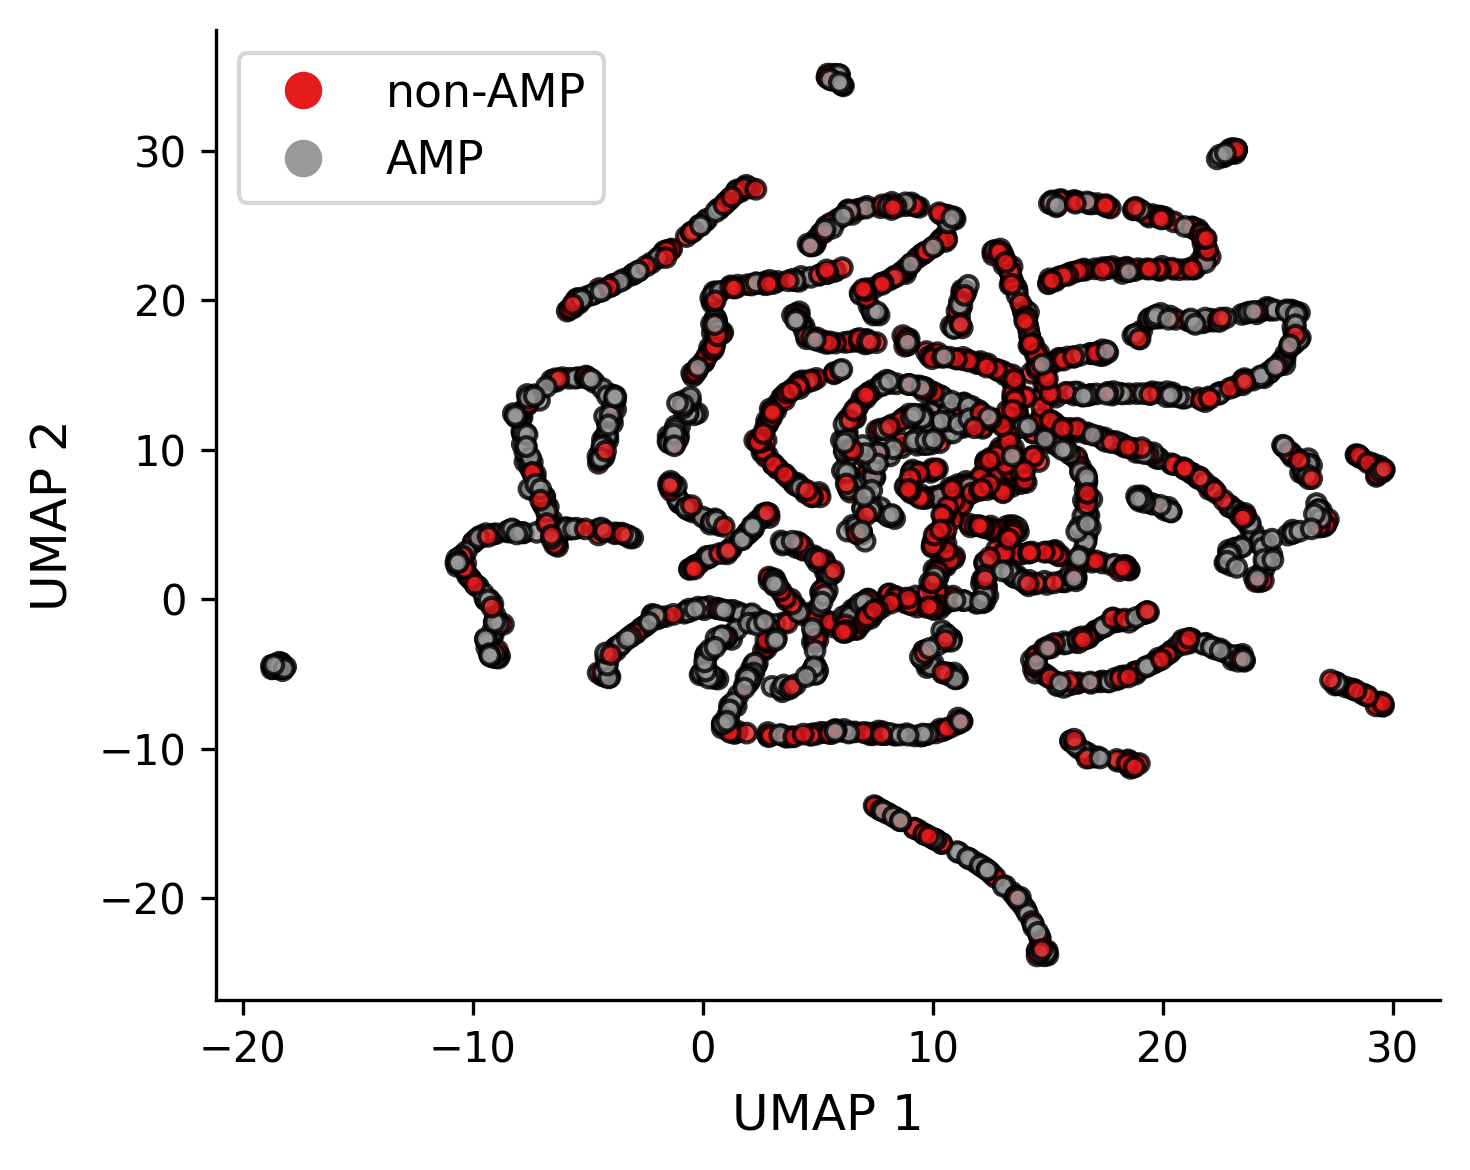

In [13]:
# AMP labels
unique_labels = np.unique(y)
label_names = ['non-AMP', 'AMP']

# 2D UMAP plot
plt.figure(figsize=(5, 4), dpi=300)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], 
                      c=y, cmap='Set1', s=20, edgecolor='k', alpha=0.8)

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Set1(i / (len(unique_labels) - 1)), markersize=10, label=label_names[i])
           for i in unique_labels]
plt.legend(handles=handles, fontsize=11, loc='best')

# Set coordinate labels
plt.xlabel('UMAP 1', fontsize=12, labelpad=5)
plt.ylabel('UMAP 2', fontsize=12, labelpad=5)

# Clean up the plot
plt.grid(False)
sns.despine()
plt.tight_layout()

# Save the plot 
#plt.savefig('Eco_UMAP.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Extract the ECFP features
ECFP = X_norm.drop(columns=['Q', 'frac_CC'])
ECFP.head()

,ECFP0,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,ECFP9,...,ECFP502,ECFP503,ECFP504,ECFP505,ECFP506,ECFP507,ECFP508,ECFP509,ECFP510,ECFP511
0,0.753086,0.697674,0.614035,0.357143,0.250000,0.1,0.05,0.0,0.000000,0.00,...,0.000000,0.047619,0.787879,0.181818,0.000000,0.25,0.000,0.000000,0.00,0.125
1,0.512346,0.604651,0.614035,0.357143,0.423913,0.4,0.40,0.1,0.000000,0.00,...,0.000000,0.380952,0.636364,0.181818,0.000000,0.00,0.000,0.222222,0.00,0.500
2,0.629630,0.465116,0.596491,0.071429,0.000000,0.0,0.00,0.1,0.000000,0.00,...,0.333333,0.000000,0.545455,0.000000,0.166667,0.25,0.125,0.000000,0.00,0.000
3,0.617284,0.558140,0.631579,0.071429,0.065217,0.0,0.00,0.1,0.000000,0.00,...,0.166667,0.000000,0.545455,0.090909,0.166667,0.00,0.125,0.000000,0.25,0.000
4,0.351852,0.372093,0.368421,0.214286,0.152174,0.0,0.00,0.0,0.047619,0.25,...,0.000000,0.047619,0.333333,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.000


In [15]:
# Initialize UMAP 
reducer = umap.UMAP(n_neighbors=15, min_dist=0.8, n_components=2, 
                    metric='manhattan', random_state=random_state)

# Fit transform
X_umap = reducer.fit_transform(ECFP)

print(X_umap.shape)

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


(2652, 2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

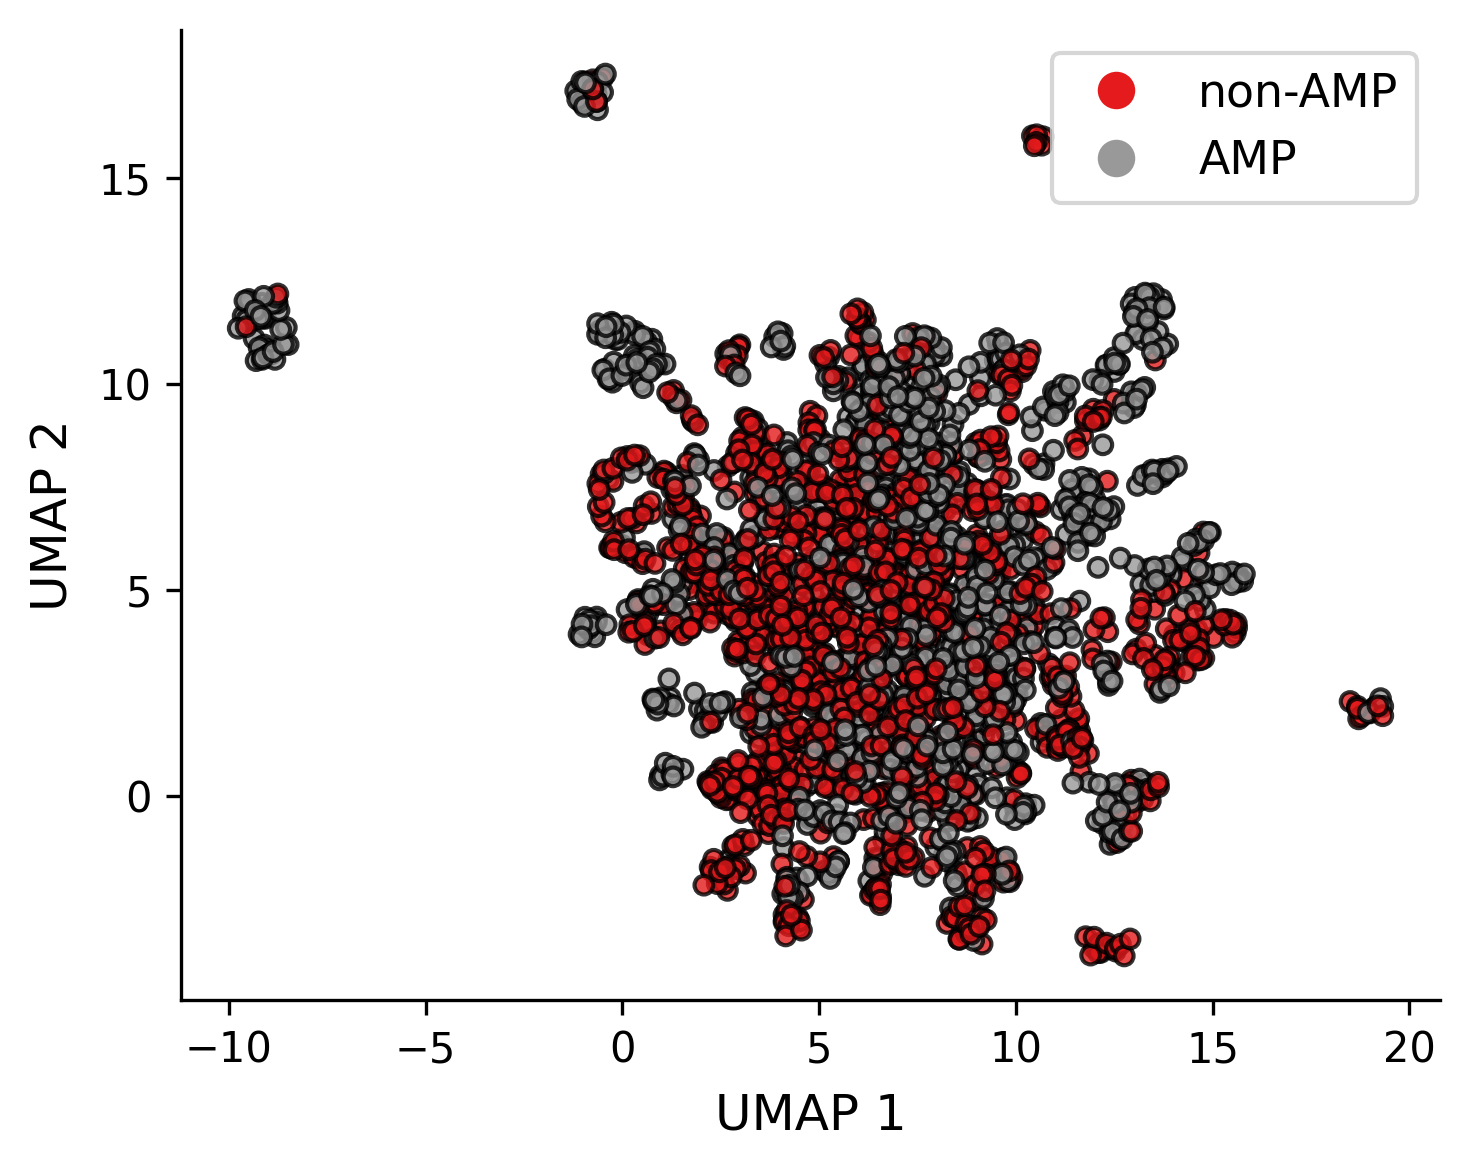

In [16]:
# 2D UMAP plot
plt.figure(figsize=(5, 4), dpi=300)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], 
                      c=y, cmap='Set1', s=20, edgecolor='k', alpha=0.8)

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Set1(i / (len(unique_labels) - 1)), markersize=10, label=label_names[i])
           for i in unique_labels]
plt.legend(handles=handles, fontsize=11, loc='best')

# Set coordinate labels
plt.xlabel('UMAP 1', fontsize=12, labelpad=5)
plt.ylabel('UMAP 2', fontsize=12, labelpad=5)

# Clean up the plot
plt.grid(False)
sns.despine()
plt.tight_layout()

plt.show()

In [17]:
# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.15, stratify=y,
                                                   random_state=random_state)

print("Size of training set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_test.shape[0]))

<IPython.core.display.Javascript object>

Size of training set: 2254   size of test set: 398



In [68]:
# Convert X_test to dataframe
X_test_df = pd.DataFrame(X_test)

# Add target column
X_test_df['Ecoli'] = y_test

# Save to csv
X_test_df.to_csv('dataset/X_test.csv')
X_test_df

<IPython.core.display.Javascript object>

,Q,frac_CC,ECFP0,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,...,ECFP503,ECFP504,ECFP505,ECFP506,ECFP507,ECFP508,ECFP509,ECFP510,ECFP511,Ecoli
1994,0.500000,0.224603,0.512346,0.255814,0.421053,0.071429,0.097826,0.05,0.00,0.0,...,0.047619,0.424242,0.000000,0.000000,0.00,0.000,0.000000,0.0,0.000,1
2625,0.423077,0.346604,0.345679,0.116279,0.175439,0.142857,0.000000,0.05,0.00,0.0,...,0.000000,0.181818,0.000000,0.000000,0.00,0.000,0.000000,0.0,0.000,1
1354,0.153846,0.195355,0.179012,0.302326,0.245614,0.357143,0.097826,0.15,0.05,0.2,...,0.047619,0.242424,0.272727,0.000000,0.25,0.125,0.111111,0.0,0.125,0
2572,0.538462,0.319228,0.518519,0.348837,0.421053,0.071429,0.250000,0.15,0.00,0.0,...,0.095238,0.484848,0.090909,0.000000,0.00,0.000,0.222222,0.0,0.125,1
1001,0.307692,0.370990,0.530864,0.581395,0.508772,0.142857,0.108696,0.05,0.05,0.0,...,0.047619,0.636364,0.090909,0.000000,0.00,0.125,0.000000,0.0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0.346154,0.470628,0.376543,0.395349,0.298246,0.142857,0.108696,0.15,0.05,0.1,...,0.142857,0.393939,0.181818,0.000000,0.00,0.125,0.000000,0.0,0.000,1
2563,0.307692,0.679836,0.111111,0.139535,0.122807,0.000000,0.260870,0.15,0.05,0.0,...,0.142857,0.121212,0.000000,0.000000,0.00,0.000,0.000000,0.0,0.000,1
109,0.538462,0.312904,0.666667,0.674419,0.596491,0.357143,0.043478,0.00,0.00,0.0,...,0.000000,0.696970,0.272727,0.166667,0.00,0.000,0.444444,0.0,0.125,1
1051,0.423077,0.295455,0.388889,0.418605,0.491228,0.214286,0.282609,0.05,0.05,0.0,...,0.047619,0.424242,0.000000,0.000000,0.25,0.125,0.000000,0.5,0.250,1


## Logit

In [18]:
# Performing Bayesian search to optimize parameters for logit
logit = LogisticRegression(max_iter=5000, random_state=random_state)

param = {'C': (1e-1,1e1, 'log-uniform')} 

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
logit_cv = BayesSearchCV(estimator=logit, search_spaces=param, cv=cv, scoring='roc_auc', 
                         n_jobs=-1, random_state=random_state)

start_time = time.time()
logit_cv.fit(X_train, y_train)
end_time = time.time()
time_taken = timedelta(seconds=end_time - start_time)

print('best parameters: ', logit_cv.best_params_)
print('best score after search cv:', logit_cv.best_score_)
print('time taken: {}'.format(time_taken))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best parameters:  OrderedDict([('C', 0.6379388708625874)])
best score after search cv: 0.8597253532550931
time taken: 0:00:37.900712


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

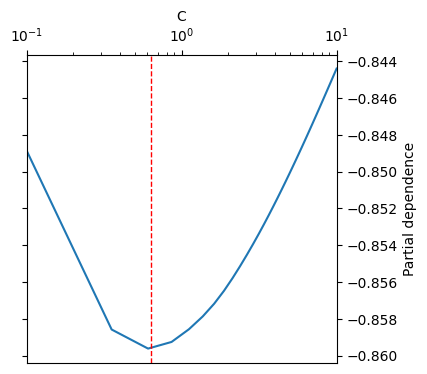

In [19]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(4, 4))
plot_objective(logit_cv.optimizer_results_[0], ax=ax)
plt.show()

In [20]:
# Train logit
logit_tuned = LogisticRegression(**logit_cv.best_params_, max_iter=5000,
                                 n_jobs=-1, random_state=random_state)

logit_tuned.fit(X_train, y_train)

<IPython.core.display.Javascript object>

LogisticRegression(C=0.6379388708625874, max_iter=5000, n_jobs=-1,
                   random_state=42)

In [21]:
# Print intercept & coefficients
print('intercept:', logit_tuned.intercept_)
print('coef:', logit_tuned.coef_, end='\n')

intercept: [-3.73240632]
coef: [[ 1.45867602e+00  1.41554412e+00  3.90219514e-01  4.25424550e-02
  -2.94982803e-01 -9.52058733e-01  2.86545392e-01  1.28722346e-01
   7.48521391e-02 -4.99178222e-02 -2.13185375e-01 -6.58686502e-01
  -4.51399028e-01 -6.19576029e-01 -4.84841369e-01 -3.23554317e-01
  -1.82391783e-01  9.56442662e-02  1.78337644e-01  6.54172705e-01
  -8.33834702e-03  1.50917094e-02 -8.16592704e-01 -7.14064679e-01
  -2.20723374e-01  1.54863389e-01 -1.07336539e+00 -8.24833681e-02
  -1.45954459e-01 -6.27527587e-01  7.97350613e-01 -1.49014169e-01
   1.25569344e-01  3.38687505e-01 -7.29483233e-01  1.95030320e-03
  -4.36074172e-02  6.08982642e-01  3.78015007e-01  4.40773074e-01
  -3.91831842e-01  1.03328333e-01 -3.23162844e-01  2.94873621e-01
   6.11020716e-03  6.63231868e-01  4.30431199e-01 -3.87671919e-01
   2.19107717e-01  9.28750165e-01  3.43958448e-01  9.02358722e-02
  -4.92959774e-02 -1.96627762e-01  2.21063033e-01  7.03344326e-01
  -2.67251849e-01 -6.93749187e-01 -4.87350197

In [22]:
# Evaluate the logit model on the training set
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'matthews_corrcoef']
cv_results = cross_validate(logit_tuned, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

print("Performance of the logit model on the training set:\nAcc: {:.4f}\nPr: {:.4f}\nSn: {:.4f}\nF1: {:.4f}\nMCC: {:.4f}\nAUROC: {:.4f}".format(
    np.median(cv_results['test_accuracy']),
    np.median(cv_results['test_precision']),
    np.median(cv_results['test_recall']),
    np.median(cv_results['test_f1']),
    np.median(cv_results['test_matthews_corrcoef']),
    np.median(cv_results['test_roc_auc'])
))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of the logit model on the training set:
Acc: 0.7938
Pr: 0.8009
Sn: 0.7788
F1: 0.7890
MCC: 0.5879
AUROC: 0.8653


In [23]:
# Evaluate the logit model on the test set
y_pred_logit = logit_tuned.predict(X_test)
y_proba_logit = logit_tuned.predict_proba(X_test)[:, 1]

print("Performance of the logit model on the test set:")
print("Acc: {:.4f}".format(accuracy_score(y_test, y_pred_logit)))
print("Pr: {:.4f}".format(precision_score(y_test, y_pred_logit)))
print("Sn: {:.4f}".format(recall_score(y_test, y_pred_logit)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_logit)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_test, y_pred_logit)))
print("AUROC: {:.4f}".format(roc_auc_score(y_test, y_proba_logit)))

Performance of the logit model on the test set:
Acc: 0.7638
Pr: 0.7536
Sn: 0.7839
F1: 0.7685
MCC: 0.5281
AUROC: 0.8349


In [24]:
# Save the logit model
#joblib.dump(logit_tuned, "model/logit.pkl")
#joblib.dump(scaler_qc, "model/scaler_qc.pkl")
#joblib.dump(scaler_ecfp, "model/scaler_ecfp.pkl")
#joblib.dump(normalizer, "model/normalizer.pkl")

## KNN

In [25]:
# Performing Bayesian search to optimize parameters for KNN
knn = KNeighborsClassifier()

param = {'n_neighbors': (3,20),
         'weights': ['distance', 'uniform'],
         'p': (1,2,3),
         'metric': ['minkowski', 'manhattan', 'euclidean']
         }

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
knn_cv = BayesSearchCV(estimator=knn, search_spaces=param, cv=cv, scoring='roc_auc', 
                       n_jobs=-1, random_state=random_state)

start_time = time.time()
knn_cv.fit(X_train, y_train)
end_time = time.time()
time_taken = timedelta(seconds=end_time - start_time)

print('best parameters: ', knn_cv.best_params_)
print('best score after search cv:', knn_cv.best_score_)
print('time taken: {}'.format(time_taken))

<IPython.core.display.Javascript object>

best parameters:  OrderedDict([('metric', 'manhattan'), ('n_neighbors', 8), ('p', 1), ('weights', 'distance')])
best score after search cv: 0.8904567283487911
time taken: 0:00:51.283354


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

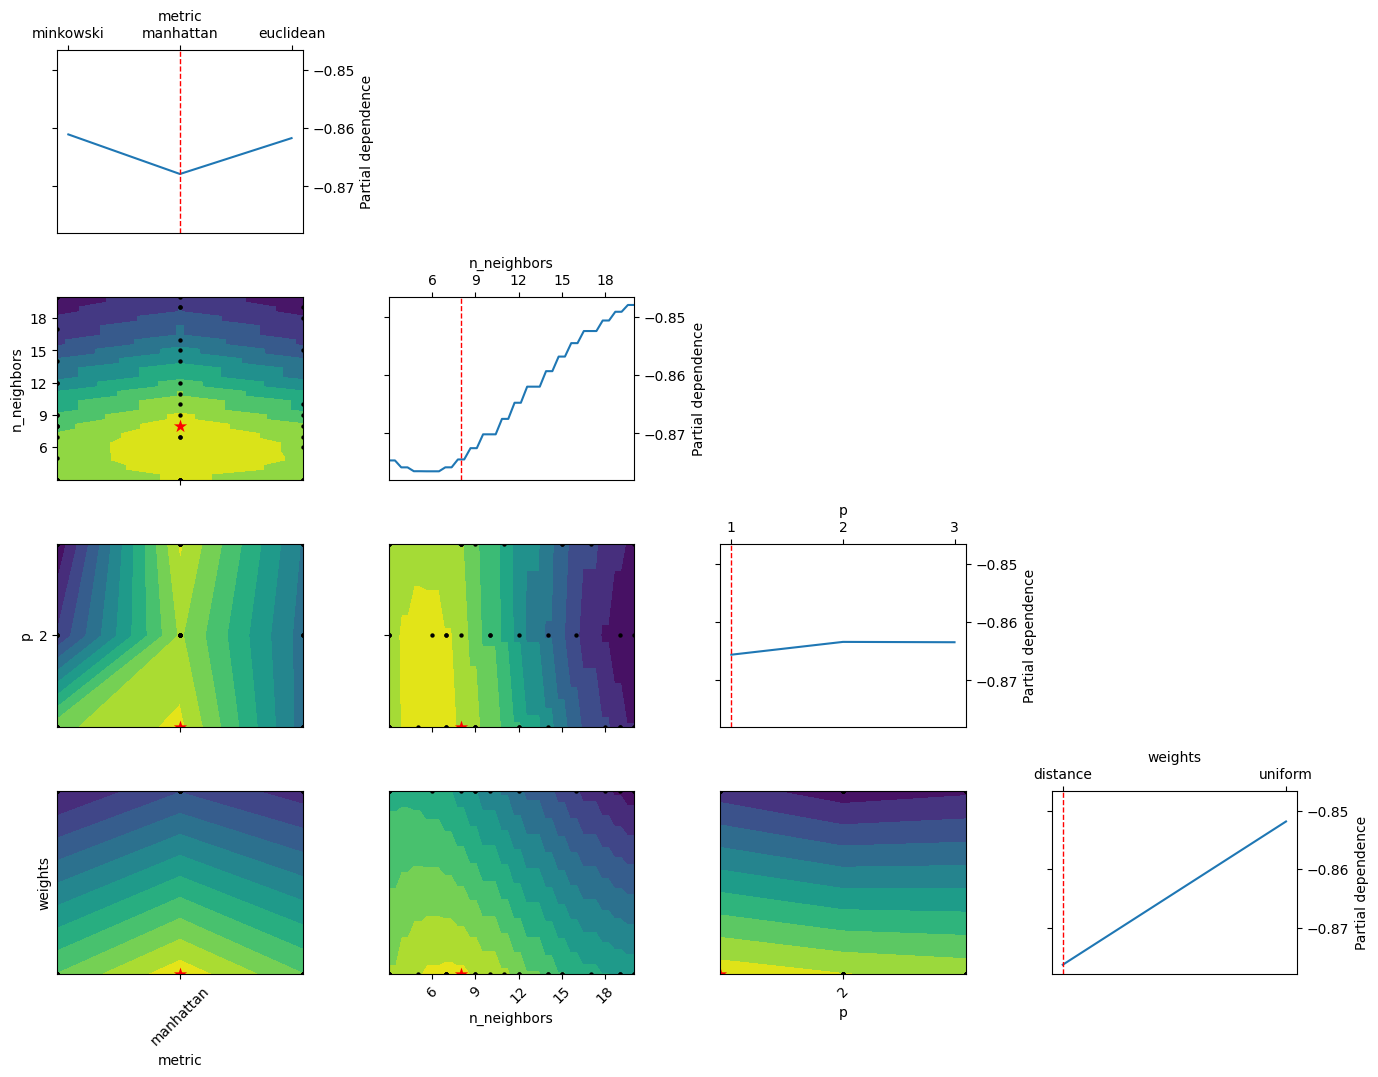

In [26]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(16, 12))
plot_objective(knn_cv.optimizer_results_[0], ax=ax)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

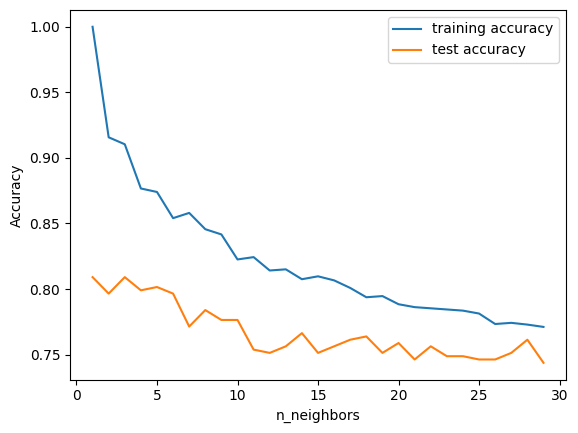

In [27]:
# Find the optimum k
train_acc = []
test_acc = []
# try n_neighbors from 1 to 30
neighbors_settings = range(1, 30)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
   
    # record training set accuracy
    train_acc.append(knn.score(X_train, y_train))
   
    # record generalization accuracy
    test_acc.append(knn.score(X_test, y_test))

plt.plot(neighbors_settings, train_acc, label="training accuracy")
plt.plot(neighbors_settings, test_acc, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [28]:
# Train KNN
knn_tuned = KNeighborsClassifier(n_neighbors=6, weights='distance', 
                                 p=1, metric='manhattan', n_jobs=-1)

knn_tuned.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=6, p=1,
                     weights='distance')

In [29]:
# Evaluate the KNN model on the training set
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'matthews_corrcoef']
cv_results = cross_validate(knn_tuned, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

print("Performance of the KNN model on the training set:\nAcc: {:.4f}\nPr: {:.4f}\nSn: {:.4f}\nF1: {:.4f}\nMCC: {:.4f}\nAUROC: {:.4f}".format(
    np.median(cv_results['test_accuracy']),
    np.median(cv_results['test_precision']),
    np.median(cv_results['test_recall']),
    np.median(cv_results['test_f1']),
    np.median(cv_results['test_matthews_corrcoef']),
    np.median(cv_results['test_roc_auc'])
))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of the KNN model on the training set:
Acc: 0.8156
Pr: 0.8092
Sn: 0.8186
F1: 0.8162
MCC: 0.6334
AUROC: 0.9010


In [30]:
# Evaluate the KNN model on the test set
y_pred_knn = knn_tuned.predict(X_test)
y_proba_knn = knn_tuned.predict_proba(X_test)[:, 1]

print("Performance of the KNN model on the test set:")
print("Acc: {:.4f}".format(accuracy_score(y_test, y_pred_knn)))
print("Pr: {:.4f}".format(precision_score(y_test, y_pred_knn)))
print("Sn: {:.4f}".format(recall_score(y_test, y_pred_knn)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_knn)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_test, y_pred_knn)))
print("AUROC: {:.4f}".format(roc_auc_score(y_test, y_proba_knn)))

Performance of the KNN model on the test set:
Acc: 0.7990
Pr: 0.7820
Sn: 0.8291
F1: 0.8049
MCC: 0.5991
AUROC: 0.8772


In [31]:
# Save the KNN model
#joblib.dump(knn_tuned, "model/knn.pkl")

## SVC

In [32]:
# Performing Bayesian search to optimize parameters for SVC rbf
svc = SVC(random_state=random_state, kernel='rbf')

param = {'C': (1,1e2, 'log-uniform'), 
         'gamma': (1e-2,1,'log-uniform')}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
svc_cv = BayesSearchCV(estimator=svc, search_spaces=param, cv=cv, scoring='roc_auc', 
                       n_jobs=-1, random_state=random_state)

start_time = time.time()
svc_cv.fit(X_train, y_train)
end_time = time.time()
time_taken = timedelta(seconds=end_time - start_time)

print('best parameters: ', svc_cv.best_params_)
print('best score after search cv:', svc_cv.best_score_)
print('time taken: {}'.format(time_taken))

<IPython.core.display.Javascript object>

best parameters:  OrderedDict([('C', 8.551143274782264), ('gamma', 0.22379351515634813)])
best score after search cv: 0.9182661272277727
time taken: 0:02:54.953274


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

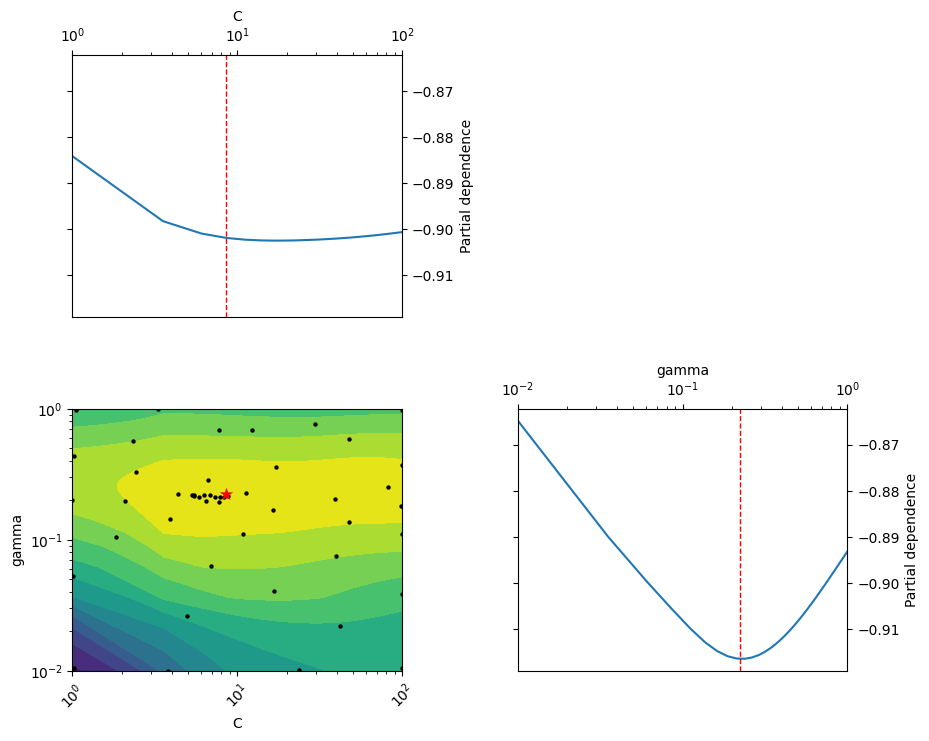

In [33]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(10, 8))
plot_objective(svc_cv.optimizer_results_[0], ax=ax)
plt.show()

In [34]:
# Train SVC rbf
svc_tuned = SVC(kernel='rbf', **svc_cv.best_params_, 
              probability=True, random_state=random_state)

svc_tuned.fit(X_train, y_train)

SVC(C=8.551143274782264, gamma=0.22379351515634813, probability=True,
    random_state=42)

In [35]:
# Evaluate the SVC rbf model on the training set
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'matthews_corrcoef']
cv_results = cross_validate(svc_tuned, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

print("Performance of the SVC model on the training set:\nAcc: {:.4f}\nPr: {:.4f}\nSn: {:.4f}\nF1: {:.4f}\nMCC: {:.4f}\nAUROC: {:.4f}".format(
    np.median(cv_results['test_accuracy']),
    np.median(cv_results['test_precision']),
    np.median(cv_results['test_recall']),
    np.median(cv_results['test_f1']),
    np.median(cv_results['test_matthews_corrcoef']),
    np.median(cv_results['test_roc_auc'])
))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of the SVC model on the training set:
Acc: 0.8404
Pr: 0.8422
Sn: 0.8667
F1: 0.8463
MCC: 0.6831
AUROC: 0.9181


In [36]:
# Evaluate the SVC rbf model on the test set
y_pred_svc = svc_tuned.predict(X_test)
y_proba_svc = svc_tuned.predict_proba(X_test)[:, 1]

print("Performance of the SVC model on the test set:")
print("Acc: {:.4f}".format(accuracy_score(y_test, y_pred_svc)))
print("Pr: {:.4f}".format(precision_score(y_test, y_pred_svc)))
print("Sn: {:.4f}".format(recall_score(y_test, y_pred_svc)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_svc)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_test, y_pred_svc)))
print("AUROC: {:.4f}".format(roc_auc_score(y_test, y_proba_svc)))

Performance of the SVC model on the test set:
Acc: 0.8568
Pr: 0.8586
Sn: 0.8543
F1: 0.8564
MCC: 0.7136
AUROC: 0.9184


In [37]:
# Save the SVC rbf model
#joblib.dump(svc_tuned, "model/svc.pkl")

## RF

In [38]:
# Perform Bayesian search to optimize parameters for RF
rf = RandomForestClassifier(random_state=random_state, 
                            criterion='entropy', min_samples_split=2, 
                            min_samples_leaf=1, max_features='sqrt')
                            

param = {'n_estimators': (100,1200), 
         #'criterion': ['gini', 'entropy'], 
         'max_depth': (5,25), 
         #'min_samples_split': (2,20),
         #'min_samples_leaf': (1,10),
         #'max_features': ['sqrt', 'log2']
        }

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
rf_cv = BayesSearchCV(estimator=rf, search_spaces=param, cv=cv, scoring='roc_auc', 
                          n_jobs=-1, random_state=random_state)

start_time = time.time()
rf_cv.fit(X_train, y_train)
end_time = time.time()
time_taken = timedelta(seconds=end_time - start_time)

print('best parameters: ', rf_cv.best_params_)
print('best score after search cv:', rf_cv.best_score_)
print('time taken: {}'.format(time_taken))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The objective has been evaluated at point [25, 1200] before, using random point [9, 939]


best parameters:  OrderedDict([('max_depth', 21), ('n_estimators', 582)])
best score after search cv: 0.9213698004654131
time taken: 0:03:42.815733


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

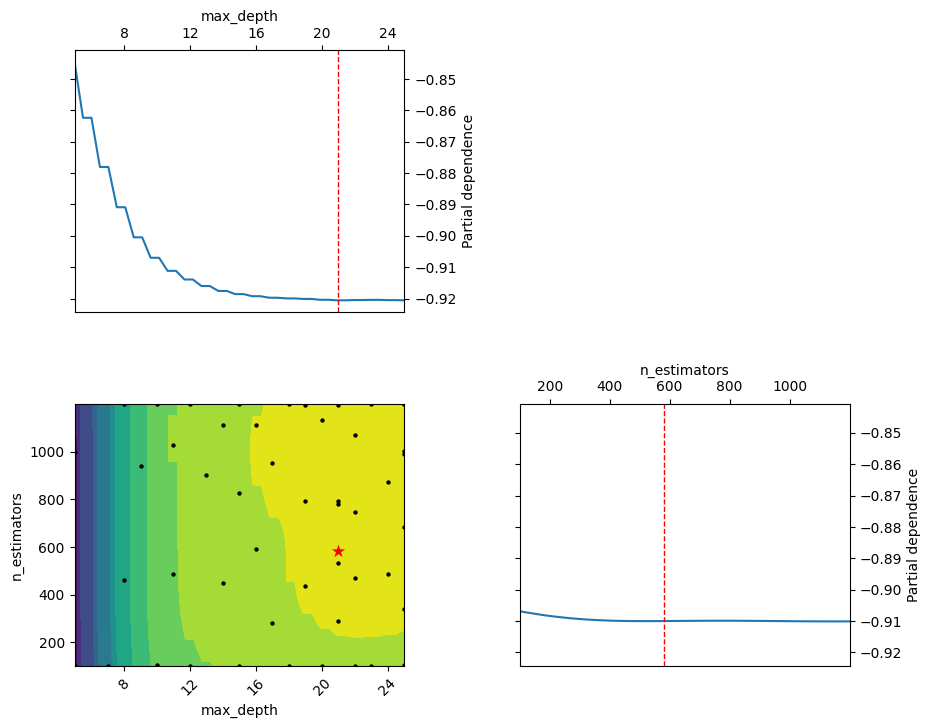

In [39]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(10, 8))
plot_objective(rf_cv.optimizer_results_[0], ax=ax)
plt.show()

In [40]:
# Train RF 
rf_tuned = RandomForestClassifier(**rf_cv.best_params_, criterion='entropy', 
                                  max_features='sqrt', min_samples_split=2, 
                                  min_samples_leaf=1, n_jobs=-1, 
                                  random_state=random_state)

rf_tuned.fit(X_train, y_train)

<IPython.core.display.Javascript object>

RandomForestClassifier(criterion='entropy', max_depth=21, n_estimators=582,
                       n_jobs=-1, random_state=42)

In [41]:
# Evaluate the RF model on the training set 
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'matthews_corrcoef']
cv_results = cross_validate(rf_tuned, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

print("Performance of the RF model on the training set:\nAcc: {:.4f}\nPr: {:.4f}\nSn: {:.4f}\nF1: {:.4f}\nMCC: {:.4f}\nAUROC: {:.4f}".format(
    np.median(cv_results['test_accuracy']),
    np.median(cv_results['test_precision']),
    np.median(cv_results['test_recall']),
    np.median(cv_results['test_f1']),
    np.median(cv_results['test_matthews_corrcoef']),
    np.median(cv_results['test_roc_auc'])
))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of the RF model on the training set:
Acc: 0.8511
Pr: 0.8312
Sn: 0.8717
F1: 0.8559
MCC: 0.7043
AUROC: 0.9202


In [42]:
# Evaluate the RF model on the test set
y_pred_rf = rf_tuned.predict(X_test)
y_proba_rf = rf_tuned.predict_proba(X_test)[:, 1]

print("Performance of the RF model on the test set:")
print("Acc: {:.4f}".format(accuracy_score(y_test, y_pred_rf)))
print("Pr: {:.4f}".format(precision_score(y_test, y_pred_rf)))
print("Sn: {:.4f}".format(recall_score(y_test, y_pred_rf)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_rf)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_test, y_pred_rf)))
print("AUROC: {:.4f}".format(roc_auc_score(y_test, y_proba_rf)))

Performance of the RF model on the test set:
Acc: 0.8568
Pr: 0.8550
Sn: 0.8593
F1: 0.8571
MCC: 0.7136
AUROC: 0.9149


In [43]:
# Save the RF model
#joblib.dump(rf_tuned, "model/rf.pkl")

## XGB

In [44]:
# Perform Bayesian search to optimize parameters for XGB
xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic',
                    random_state=random_state, gamma=1e-1, max_depth=28, subsample=0.75, 
                    colsample_bytree=1, reg_lambda=1e-3, min_child_weight=1)   

param = {'learning_rate': (1e-2,1,'log-uniform'),
         'n_estimators': (50,800),
         #'gamma': (1e-6,1e2,'log-uniform'), 
         #'max_depth': (5,30),
         #'subsample': (0.1,1),
         #'colsample_bytree': (0.1,1),
         #'reg_alpha': (1e-2,1e2,'log-uniform'),
         #'reg_lambda': (1e-5,1e2,'log-uniform'),
         #'min_child_weight': (1,10)
        }

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
xgb_cv = BayesSearchCV(estimator=xgb, search_spaces=param, cv=10, scoring='roc_auc',
                      random_state=random_state)

start_time = time.time()
xgb_cv.fit(X_train, y_train)
end_time = time.time()
time_taken = timedelta(seconds=end_time - start_time)

print('best parameters: ', xgb_cv.best_params_)
print('best score after search cv:', xgb_cv.best_score_)
print('time taken: {}'.format(time_taken))

<IPython.core.display.Javascript object>

best parameters:  OrderedDict([('learning_rate', 0.012771026165183738), ('n_estimators', 800)])
best score after search cv: 0.9354250109081146
time taken: 0:15:44.201317


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

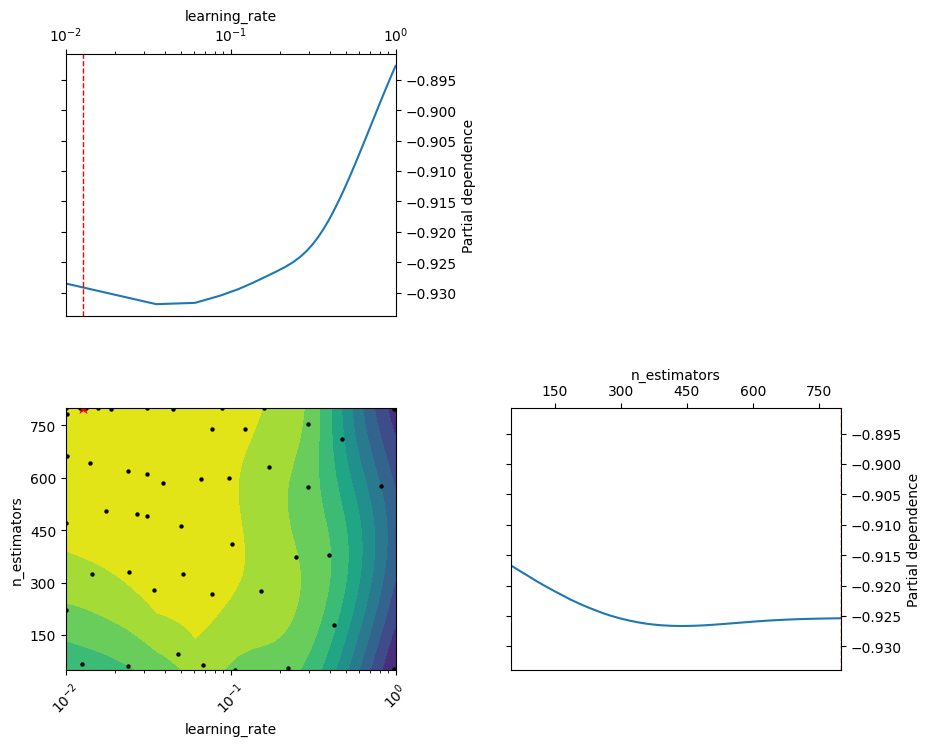

In [45]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(10, 8))
plot_objective(xgb_cv.optimizer_results_[0], ax=ax)
plt.show()

In [46]:
# Train XGB
xgb_tuned = XGBClassifier(**xgb_cv.best_params_, tree_method='gpu_hist', gpu_id=0, 
                          objective='binary:logistic', gamma=1e-1, max_depth=28, 
                          subsample=0.75, colsample_bytree=1, reg_lambda=1e-3, 
                          min_child_weight=1, random_state=random_state)

xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, gpu_id=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.012771026165183738,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=28, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [47]:
# Evaluate the XGB model on the training set
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'matthews_corrcoef']
cv_results = cross_validate(xgb_tuned, X_train, y_train, cv=10, scoring=scoring)

print("Performance of the XGB model on the training set:\nAcc: {:.4f}\nPr: {:.4f}\nSn: {:.4f}\nF1: {:.4f}\nMCC: {:.4f}\nAUROC: {:.4f}".format(
    np.median(cv_results['test_accuracy']),
    np.median(cv_results['test_precision']),
    np.median(cv_results['test_recall']),
    np.median(cv_results['test_f1']),
    np.median(cv_results['test_matthews_corrcoef']),
    np.median(cv_results['test_roc_auc'])
))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of the XGB model on the training set:
Acc: 0.8600
Pr: 0.8346
Sn: 0.8844
F1: 0.8640
MCC: 0.7213
AUROC: 0.9302


In [48]:
# Evaluate the XGB model on the test set
y_pred_xgb = xgb_tuned.predict(X_test)
y_proba_xgb = xgb_tuned.predict_proba(X_test)[:, 1]

print("Performance of the XGB model on the test set")
print("Acc: {:.4f}".format(accuracy_score(y_test, y_pred_xgb)))
print("Pr: {:.4f}".format(precision_score(y_test, y_pred_xgb)))
print("Sn: {:.4f}".format(recall_score(y_test, y_pred_xgb)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_xgb)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_test, y_pred_xgb)))
print("AUROC: {:.4f}".format(roc_auc_score(y_test, y_proba_xgb)))

Performance of the XGB model on the test set
Acc: 0.8492
Pr: 0.8564
Sn: 0.8392
F1: 0.8477
MCC: 0.6986
AUROC: 0.9298


In [49]:
# Save the XGB model
#joblib.dump(xgb_tuned, "model/xgb.pkl")

## LGBM

In [50]:
# Perform Bayesian search to optimize parameters for LGBM
lgbm = LGBMClassifier(device='gpu', objective='binary', extra_trees=True, verbose=-1, 
                      random_state=random_state, num_leaves=300, max_depth=20, 
                      min_data_in_leaf=1, bagging_freq=10, bagging_fraction=1.0, 
                      feature_fraction=0.1, reg_lambda=1e-1)  

param = {'n_estimators': (500,1200),
         'learning_rate': (1e-2,1,'log-uniform'),
         #'num_leaves': (10,800),
         #'max_depth': (5,30),
         #'min_data_in_leaf': (1,100),
         #'bagging_freq': (0,50),
         #'bagging_fraction': (0.1,1.0),
         #'feature_fraction': (0.1,1.0),
         #'reg_alpha': (1e-2,1e2,'log-uniform'),
         #'reg_lambda': (1e-5,1e2,'log-uniform'),
         #'dropout_rate': (0,0.5)
        }

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
lgbm_cv = BayesSearchCV(estimator=lgbm, search_spaces=param, cv=cv, scoring='roc_auc',
                       random_state=random_state)

start_time = time.time()
lgbm_cv.fit(X_train, y_train)
end_time = time.time()
time_taken = timedelta(seconds=end_time - start_time)

print('best parameters: ', lgbm_cv.best_params_)
print('best score after search cv:', lgbm_cv.best_score_)
print('time taken: {}'.format(time_taken))

<IPython.core.display.Javascript object>

best parameters:  OrderedDict([('learning_rate', 0.044986971995002435), ('n_estimators', 1196)])
best score after search cv: 0.9298813113231823
time taken: 0:40:38.719094


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

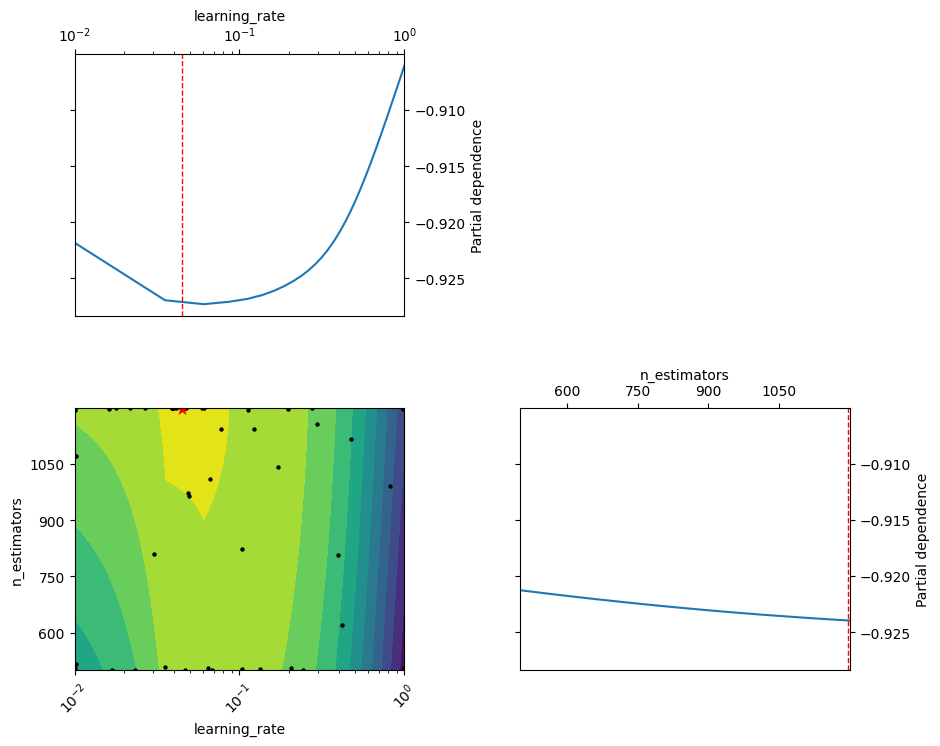

In [51]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(10, 8))
plot_objective(lgbm_cv.optimizer_results_[0], ax=ax)
plt.show()

In [52]:
# Train LGBM 
lgbm_tuned = LGBMClassifier(**lgbm_cv.best_params_, device='gpu', objective='binary', 
                            extra_trees=True, verbose=-1, num_leaves=300, max_depth=20, 
                            min_data_in_leaf=1, bagging_freq=10, bagging_fraction=1.0, 
                            feature_fraction=0.10, reg_lambda=1e-1, random_state=random_state)

lgbm_tuned.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=10, device='gpu',
               extra_trees=True, feature_fraction=0.1,
               learning_rate=0.044986971995002435, max_depth=20,
               min_data_in_leaf=1, n_estimators=1196, num_leaves=300,
               objective='binary', random_state=42, reg_lambda=0.1, verbose=-1)

In [53]:
# Evaluate the LGBM model on the training set
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'matthews_corrcoef']
cv_results = cross_validate(lgbm_tuned, X_train, y_train, cv=10, scoring=scoring)

print("Performance of the LGBM model on the training set:\nAcc: {:.4f}\nPr: {:.4f}\nSn: {:.4f}\nF1: {:.4f}\nMCC: {:.4f}\nAUROC: {:.4f}".format(
    np.median(cv_results['test_accuracy']),
    np.median(cv_results['test_precision']),
    np.median(cv_results['test_recall']),
    np.median(cv_results['test_f1']),
    np.median(cv_results['test_matthews_corrcoef']),
    np.median(cv_results['test_roc_auc'])
))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of the LGBM model on the training set:
Acc: 0.8492
Pr: 0.8461
Sn: 0.8673
F1: 0.8495
MCC: 0.6989
AUROC: 0.9253


In [54]:
# Evaluate the LGBM model on the test set
y_pred_lgbm = lgbm_tuned.predict(X_test)
y_proba_lgbm = lgbm_tuned.predict_proba(X_test)[:, 1]

print("Performance of the LGBM model on the test set:")
print("Acc: {:.4f}".format(accuracy_score(y_test, y_pred_lgbm)))
print("Pr: {:.4f}".format(precision_score(y_test, y_pred_lgbm)))
print("Sn: {:.4f}".format(recall_score(y_test, y_pred_lgbm)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_lgbm)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_test, y_pred_lgbm)))
print("AUROC: {:.4f}".format(roc_auc_score(y_test, y_proba_lgbm)))

Performance of the LGBM model on the test set:
Acc: 0.8618
Pr: 0.8636
Sn: 0.8593
F1: 0.8615
MCC: 0.7236
AUROC: 0.9231


In [55]:
# Save the LGBM model
#joblib.dump(lgbm_tuned, "model/lgbm.pkl")

## DF

In [58]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Perform Bayesian search to optimize parameters for deepforest
dforest = CascadeForestClassifier(use_predictor=True, predictor='forest',
                                  n_jobs=-1, n_tolerant_rounds=5, verbose=0,
                                  random_state=random_state, criterion='entropy', 
                                  n_estimators=2, min_samples_split=2, 
                                  min_samples_leaf=1)
                                  
                                   
param = {#'criterion': ['gini','entropy'],
         #'n_estimators': (2,6),
         'n_trees': (50,1000),
         'max_depth': (5,30), 
         #'min_samples_split': (2,10),
         #'min_samples_leaf': (1,10)
        }

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
dforest_cv = BayesSearchCV(estimator=dforest, search_spaces=param, cv=cv, 
                              n_jobs=-1, verbose=0, random_state=random_state)

start_time = time.time()
dforest_cv.fit(X_train, y_train)
end_time = time.time()
time_taken = timedelta(seconds=end_time - start_time)

# Print best parameters
print('best parameters: ', dforest_cv.best_params_)
print('best score after search cv:', dforest_cv.best_score_)
print('time taken: {}'.format(time_taken))

<IPython.core.display.Javascript object>

best parameters:  OrderedDict([('max_depth', 27), ('n_trees', 546)])
best score after search cv: 0.8575771878072762
time taken: 0:52:15.507078


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

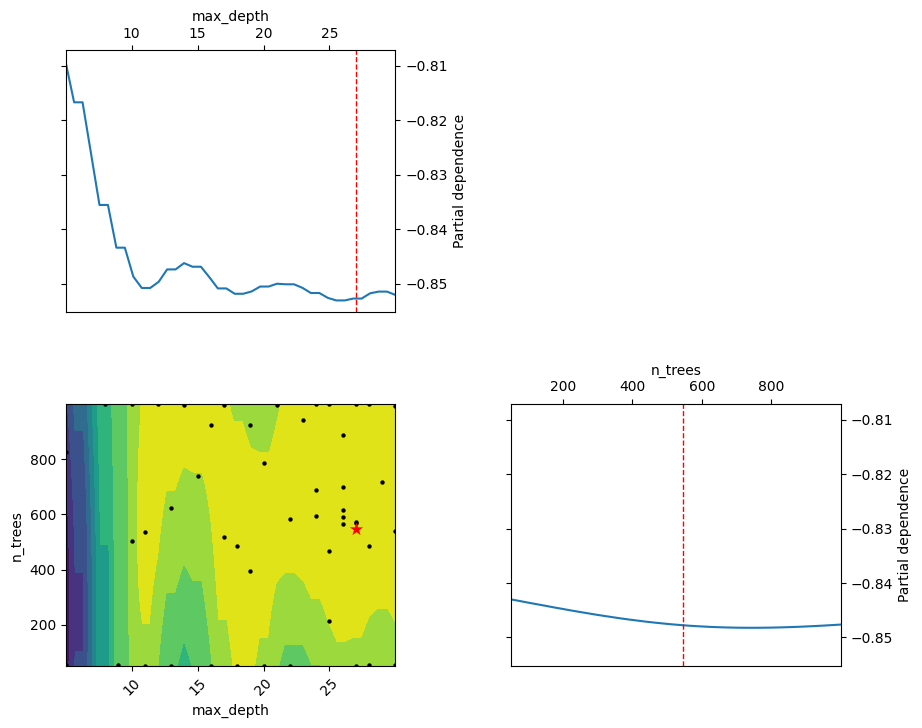

In [59]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(10, 8))
plot_objective(dforest_cv.optimizer_results_[0], ax=ax)
plt.show()

In [60]:
warnings.filterwarnings('ignore', category=FutureWarning)

# Train deepforest model
dforest_tuned = CascadeForestClassifier(use_predictor=True, predictor='forest', 
                                        criterion='entropy', n_estimators=2, 
                                        n_trees=546, max_depth=27, 
                                        min_samples_split=2, min_samples_leaf=1, 
                                        n_tolerant_rounds=5, n_jobs=-1, 
                                        random_state=random_state)

dforest_tuned.fit(X_train, y_train)

[2025-04-14 06:29:24.761] Start to fit the model:
[2025-04-14 06:29:24.761] Fitting cascade layer = 0 
[2025-04-14 06:29:26.920] layer = 0  | Val Acc = 84.916 % | Elapsed = 2.159 s
[2025-04-14 06:29:26.925] Fitting cascade layer = 1 
[2025-04-14 06:29:29.156] layer = 1  | Val Acc = 85.492 % | Elapsed = 2.231 s
[2025-04-14 06:29:29.161] Fitting cascade layer = 2 
[2025-04-14 06:29:31.450] layer = 2  | Val Acc = 85.138 % | Elapsed = 2.289 s
[2025-04-14 06:29:31.450] Early stopping counter: 1 out of 5
[2025-04-14 06:29:31.456] Fitting cascade layer = 3 
[2025-04-14 06:29:33.705] layer = 3  | Val Acc = 85.004 % | Elapsed = 2.249 s
[2025-04-14 06:29:33.705] Early stopping counter: 2 out of 5
[2025-04-14 06:29:33.712] Fitting cascade layer = 4 
[2025-04-14 06:29:35.936] layer = 4  | Val Acc = 84.694 % | Elapsed = 2.224 s
[2025-04-14 06:29:35.936] Early stopping counter: 3 out of 5
[2025-04-14 06:29:35.941] Fitting cascade layer = 5 
[2025-04-14 06:29:38.136] layer = 5  | Val Acc = 84.250 % |

In [61]:
# Evaluate the deepforest model on the training set
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'matthews_corrcoef']
cv_results = cross_validate(dforest_tuned, X_train, y_train, cv=10, verbose=0, scoring=scoring)

print("Performance of the deepforest model on the training set:\nAcc: {:.4f}\nPr: {:.4f}\nSn: {:.4f}\nF1: {:.4f}\nMCC: {:.4f}\nAUROC: {:.4f}".format(
    np.median(cv_results['test_accuracy']),
    np.median(cv_results['test_precision']),
    np.median(cv_results['test_recall']),
    np.median(cv_results['test_f1']),
    np.median(cv_results['test_matthews_corrcoef']),
    np.median(cv_results['test_roc_auc'])
))

[2025-04-14 06:29:40.878] Start to fit the model:
[2025-04-14 06:29:40.878] Fitting cascade layer = 0 
[2025-04-14 06:29:43.220] layer = 0  | Val Acc = 84.862 % | Elapsed = 2.342 s
[2025-04-14 06:29:43.227] Fitting cascade layer = 1 
[2025-04-14 06:29:45.511] layer = 1  | Val Acc = 85.651 % | Elapsed = 2.284 s
[2025-04-14 06:29:45.517] Fitting cascade layer = 2 
[2025-04-14 06:29:47.865] layer = 2  | Val Acc = 85.306 % | Elapsed = 2.348 s
[2025-04-14 06:29:47.865] Early stopping counter: 1 out of 5
[2025-04-14 06:29:47.870] Fitting cascade layer = 3 
[2025-04-14 06:29:50.198] layer = 3  | Val Acc = 84.763 % | Elapsed = 2.328 s
[2025-04-14 06:29:50.198] Early stopping counter: 2 out of 5
[2025-04-14 06:29:50.204] Fitting cascade layer = 4 
[2025-04-14 06:29:52.677] layer = 4  | Val Acc = 84.517 % | Elapsed = 2.472 s
[2025-04-14 06:29:52.677] Early stopping counter: 3 out of 5
[2025-04-14 06:29:52.684] Fitting cascade layer = 5 
[2025-04-14 06:29:54.891] layer = 5  | Val Acc = 83.876 % |

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
AttributeError: 'CascadeForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home

[2025-04-14 06:30:02.150] layer = 0  | Val Acc = 84.615 % | Elapsed = 2.021 s
[2025-04-14 06:30:02.155] Fitting cascade layer = 1 
[2025-04-14 06:30:04.396] layer = 1  | Val Acc = 85.454 % | Elapsed = 2.241 s
[2025-04-14 06:30:04.403] Fitting cascade layer = 2 
[2025-04-14 06:30:06.716] layer = 2  | Val Acc = 85.059 % | Elapsed = 2.312 s
[2025-04-14 06:30:06.716] Early stopping counter: 1 out of 5
[2025-04-14 06:30:06.721] Fitting cascade layer = 3 
[2025-04-14 06:30:09.080] layer = 3  | Val Acc = 84.615 % | Elapsed = 2.359 s
[2025-04-14 06:30:09.080] Early stopping counter: 2 out of 5
[2025-04-14 06:30:09.084] Fitting cascade layer = 4 
[2025-04-14 06:30:11.722] layer = 4  | Val Acc = 84.665 % | Elapsed = 2.638 s
[2025-04-14 06:30:11.722] Early stopping counter: 3 out of 5
[2025-04-14 06:30:11.730] Fitting cascade layer = 5 
[2025-04-14 06:30:14.047] layer = 5  | Val Acc = 84.517 % | Elapsed = 2.318 s
[2025-04-14 06:30:14.047] Early stopping counter: 4 out of 5
[2025-04-14 06:30:14.05

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
AttributeError: 'CascadeForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home

[2025-04-14 06:30:21.697] layer = 0  | Val Acc = 83.826 % | Elapsed = 2.324 s
[2025-04-14 06:30:21.702] Fitting cascade layer = 1 
[2025-04-14 06:30:23.855] layer = 1  | Val Acc = 84.911 % | Elapsed = 2.153 s
[2025-04-14 06:30:23.862] Fitting cascade layer = 2 
[2025-04-14 06:30:26.153] layer = 2  | Val Acc = 84.665 % | Elapsed = 2.291 s
[2025-04-14 06:30:26.153] Early stopping counter: 1 out of 5
[2025-04-14 06:30:26.158] Fitting cascade layer = 3 
[2025-04-14 06:30:28.373] layer = 3  | Val Acc = 84.615 % | Elapsed = 2.215 s
[2025-04-14 06:30:28.373] Early stopping counter: 2 out of 5
[2025-04-14 06:30:28.380] Fitting cascade layer = 4 
[2025-04-14 06:30:30.657] layer = 4  | Val Acc = 84.221 % | Elapsed = 2.277 s
[2025-04-14 06:30:30.657] Early stopping counter: 3 out of 5
[2025-04-14 06:30:30.663] Fitting cascade layer = 5 
[2025-04-14 06:30:32.902] layer = 5  | Val Acc = 83.925 % | Elapsed = 2.239 s
[2025-04-14 06:30:32.902] Early stopping counter: 4 out of 5
[2025-04-14 06:30:32.90

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
AttributeError: 'CascadeForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home

[2025-04-14 06:30:40.509] layer = 0  | Val Acc = 84.714 % | Elapsed = 2.395 s
[2025-04-14 06:30:40.513] Fitting cascade layer = 1 
[2025-04-14 06:30:42.808] layer = 1  | Val Acc = 85.059 % | Elapsed = 2.295 s
[2025-04-14 06:30:42.812] Fitting cascade layer = 2 
[2025-04-14 06:30:45.141] layer = 2  | Val Acc = 85.059 % | Elapsed = 2.329 s
[2025-04-14 06:30:45.141] Early stopping counter: 1 out of 5
[2025-04-14 06:30:45.145] Fitting cascade layer = 3 
[2025-04-14 06:30:47.397] layer = 3  | Val Acc = 84.418 % | Elapsed = 2.252 s
[2025-04-14 06:30:47.397] Early stopping counter: 2 out of 5
[2025-04-14 06:30:47.401] Fitting cascade layer = 4 
[2025-04-14 06:30:49.523] layer = 4  | Val Acc = 84.122 % | Elapsed = 2.122 s
[2025-04-14 06:30:49.523] Early stopping counter: 3 out of 5
[2025-04-14 06:30:49.527] Fitting cascade layer = 5 
[2025-04-14 06:30:51.722] layer = 5  | Val Acc = 83.531 % | Elapsed = 2.194 s
[2025-04-14 06:30:51.722] Early stopping counter: 4 out of 5
[2025-04-14 06:30:51.72

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
AttributeError: 'CascadeForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home

[2025-04-14 06:30:59.018] layer = 0  | Val Acc = 84.574 % | Elapsed = 2.313 s
[2025-04-14 06:30:59.026] Fitting cascade layer = 1 
[2025-04-14 06:31:01.361] layer = 1  | Val Acc = 85.017 % | Elapsed = 2.335 s
[2025-04-14 06:31:01.367] Fitting cascade layer = 2 
[2025-04-14 06:31:03.723] layer = 2  | Val Acc = 84.820 % | Elapsed = 2.356 s
[2025-04-14 06:31:03.723] Early stopping counter: 1 out of 5
[2025-04-14 06:31:03.728] Fitting cascade layer = 3 
[2025-04-14 06:31:06.058] layer = 3  | Val Acc = 84.475 % | Elapsed = 2.330 s
[2025-04-14 06:31:06.058] Early stopping counter: 2 out of 5
[2025-04-14 06:31:06.063] Fitting cascade layer = 4 
[2025-04-14 06:31:08.412] layer = 4  | Val Acc = 84.475 % | Elapsed = 2.348 s
[2025-04-14 06:31:08.412] Early stopping counter: 3 out of 5
[2025-04-14 06:31:08.416] Fitting cascade layer = 5 
[2025-04-14 06:31:10.653] layer = 5  | Val Acc = 83.933 % | Elapsed = 2.236 s
[2025-04-14 06:31:10.653] Early stopping counter: 4 out of 5
[2025-04-14 06:31:10.65

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
AttributeError: 'CascadeForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home

[2025-04-14 06:31:18.134] layer = 0  | Val Acc = 83.687 % | Elapsed = 2.212 s
[2025-04-14 06:31:18.141] Fitting cascade layer = 1 
[2025-04-14 06:31:20.459] layer = 1  | Val Acc = 84.722 % | Elapsed = 2.317 s
[2025-04-14 06:31:20.463] Fitting cascade layer = 2 
[2025-04-14 06:31:22.766] layer = 2  | Val Acc = 84.179 % | Elapsed = 2.303 s
[2025-04-14 06:31:22.766] Early stopping counter: 1 out of 5
[2025-04-14 06:31:22.770] Fitting cascade layer = 3 
[2025-04-14 06:31:25.065] layer = 3  | Val Acc = 83.637 % | Elapsed = 2.295 s
[2025-04-14 06:31:25.065] Early stopping counter: 2 out of 5
[2025-04-14 06:31:25.071] Fitting cascade layer = 4 
[2025-04-14 06:31:27.346] layer = 4  | Val Acc = 83.637 % | Elapsed = 2.275 s
[2025-04-14 06:31:27.347] Early stopping counter: 3 out of 5
[2025-04-14 06:31:27.352] Fitting cascade layer = 5 
[2025-04-14 06:31:29.498] layer = 5  | Val Acc = 83.342 % | Elapsed = 2.145 s
[2025-04-14 06:31:29.498] Early stopping counter: 4 out of 5
[2025-04-14 06:31:29.50

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
AttributeError: 'CascadeForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home

[2025-04-14 06:31:37.185] layer = 0  | Val Acc = 84.771 % | Elapsed = 2.425 s
[2025-04-14 06:31:37.190] Fitting cascade layer = 1 
[2025-04-14 06:31:39.484] layer = 1  | Val Acc = 85.313 % | Elapsed = 2.293 s
[2025-04-14 06:31:39.488] Fitting cascade layer = 2 
[2025-04-14 06:31:41.680] layer = 2  | Val Acc = 84.771 % | Elapsed = 2.192 s
[2025-04-14 06:31:41.680] Early stopping counter: 1 out of 5
[2025-04-14 06:31:41.688] Fitting cascade layer = 3 
[2025-04-14 06:31:43.978] layer = 3  | Val Acc = 84.524 % | Elapsed = 2.290 s
[2025-04-14 06:31:43.978] Early stopping counter: 2 out of 5
[2025-04-14 06:31:43.983] Fitting cascade layer = 4 
[2025-04-14 06:31:46.224] layer = 4  | Val Acc = 83.687 % | Elapsed = 2.241 s
[2025-04-14 06:31:46.224] Early stopping counter: 3 out of 5
[2025-04-14 06:31:46.228] Fitting cascade layer = 5 
[2025-04-14 06:31:48.579] layer = 5  | Val Acc = 83.440 % | Elapsed = 2.351 s
[2025-04-14 06:31:48.579] Early stopping counter: 4 out of 5
[2025-04-14 06:31:48.58

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
AttributeError: 'CascadeForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home

[2025-04-14 06:31:56.111] layer = 0  | Val Acc = 83.194 % | Elapsed = 2.293 s
[2025-04-14 06:31:56.117] Fitting cascade layer = 1 
[2025-04-14 06:31:58.419] layer = 1  | Val Acc = 84.081 % | Elapsed = 2.303 s
[2025-04-14 06:31:58.423] Fitting cascade layer = 2 
[2025-04-14 06:32:00.765] layer = 2  | Val Acc = 83.785 % | Elapsed = 2.342 s
[2025-04-14 06:32:00.765] Early stopping counter: 1 out of 5
[2025-04-14 06:32:00.770] Fitting cascade layer = 3 
[2025-04-14 06:32:03.189] layer = 3  | Val Acc = 83.144 % | Elapsed = 2.420 s
[2025-04-14 06:32:03.190] Early stopping counter: 2 out of 5
[2025-04-14 06:32:03.194] Fitting cascade layer = 4 
[2025-04-14 06:32:05.665] layer = 4  | Val Acc = 82.849 % | Elapsed = 2.472 s
[2025-04-14 06:32:05.666] Early stopping counter: 3 out of 5
[2025-04-14 06:32:05.672] Fitting cascade layer = 5 
[2025-04-14 06:32:08.045] layer = 5  | Val Acc = 82.799 % | Elapsed = 2.373 s
[2025-04-14 06:32:08.045] Early stopping counter: 4 out of 5
[2025-04-14 06:32:08.05

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
AttributeError: 'CascadeForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home

[2025-04-14 06:32:13.366] Start to fit the model:
[2025-04-14 06:32:13.366] Fitting cascade layer = 0 
[2025-04-14 06:32:15.694] layer = 0  | Val Acc = 84.130 % | Elapsed = 2.327 s
[2025-04-14 06:32:15.698] Fitting cascade layer = 1 
[2025-04-14 06:32:18.090] layer = 1  | Val Acc = 84.919 % | Elapsed = 2.392 s
[2025-04-14 06:32:18.098] Fitting cascade layer = 2 
[2025-04-14 06:32:20.365] layer = 2  | Val Acc = 84.574 % | Elapsed = 2.267 s
[2025-04-14 06:32:20.365] Early stopping counter: 1 out of 5
[2025-04-14 06:32:20.372] Fitting cascade layer = 3 
[2025-04-14 06:32:22.714] layer = 3  | Val Acc = 84.524 % | Elapsed = 2.342 s
[2025-04-14 06:32:22.714] Early stopping counter: 2 out of 5
[2025-04-14 06:32:22.721] Fitting cascade layer = 4 
[2025-04-14 06:32:24.945] layer = 4  | Val Acc = 83.834 % | Elapsed = 2.224 s
[2025-04-14 06:32:24.945] Early stopping counter: 3 out of 5
[2025-04-14 06:32:24.951] Fitting cascade layer = 5 
[2025-04-14 06:32:27.415] layer = 5  | Val Acc = 83.539 % |

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
AttributeError: 'CascadeForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home

[2025-04-14 06:32:32.122] Start to fit the model:
[2025-04-14 06:32:32.122] Fitting cascade layer = 0 
[2025-04-14 06:32:34.142] layer = 0  | Val Acc = 83.982 % | Elapsed = 2.020 s
[2025-04-14 06:32:34.147] Fitting cascade layer = 1 
[2025-04-14 06:32:36.504] layer = 1  | Val Acc = 84.229 % | Elapsed = 2.357 s
[2025-04-14 06:32:36.509] Fitting cascade layer = 2 
[2025-04-14 06:32:39.084] layer = 2  | Val Acc = 83.637 % | Elapsed = 2.575 s
[2025-04-14 06:32:39.084] Early stopping counter: 1 out of 5
[2025-04-14 06:32:39.089] Fitting cascade layer = 3 
[2025-04-14 06:32:41.387] layer = 3  | Val Acc = 83.292 % | Elapsed = 2.298 s
[2025-04-14 06:32:41.387] Early stopping counter: 2 out of 5
[2025-04-14 06:32:41.392] Fitting cascade layer = 4 
[2025-04-14 06:32:43.757] layer = 4  | Val Acc = 82.997 % | Elapsed = 2.365 s
[2025-04-14 06:32:43.757] Early stopping counter: 3 out of 5
[2025-04-14 06:32:43.762] Fitting cascade layer = 5 
[2025-04-14 06:32:46.053] layer = 5  | Val Acc = 82.109 % |

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/rlsalas/miniconda3/envs/deepchem/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
AttributeError: 'CascadeForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of the deepforest model on the training set:
Acc: 0.8622
Pr: 0.8484
Sn: 0.8717
F1: 0.8623
MCC: 0.7265
AUROC: nan


In [62]:
# Evaluate the deepforest model on the test set
y_pred_dforest = dforest_tuned.predict(X_test)
y_proba_dforest = dforest_tuned.predict_proba(X_test)[:, 1]

print("Performance of the deepforest model on the test set:")
print("Acc: {:.4f}".format(accuracy_score(y_test, y_pred_dforest)))
print("Pr: {:.4f}".format(precision_score(y_test, y_pred_dforest)))
print("Sn: {:.4f}".format(recall_score(y_test, y_pred_dforest)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_dforest)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_test, y_pred_dforest)))
print("AUROC: {:.4f}".format(roc_auc_score(y_test, y_proba_dforest)))

[2025-04-14 06:32:51.191] Start to evalute the model:
[2025-04-14 06:32:51.194] Evaluating cascade layer = 0 
[2025-04-14 06:32:51.778] Evaluating cascade layer = 1 
[2025-04-14 06:32:52.427] Evaluating the predictor
[2025-04-14 06:32:52.607] Start to evalute the model:
[2025-04-14 06:32:52.615] Evaluating cascade layer = 0 
[2025-04-14 06:32:53.061] Evaluating cascade layer = 1 
[2025-04-14 06:32:53.697] Evaluating the predictor
Performance of the deepforest model on the test set:
Acc: 0.8668
Pr: 0.8650
Sn: 0.8693
F1: 0.8672
MCC: 0.7337
AUROC: 0.9198


In [63]:
# Save the dforest model
#joblib.dump(dforest_tuned, "model/dforest.pkl")

['model/dforest.pkl']

## Vote

In [56]:
# Train vote model 
vote = VotingClassifier(estimators=[('xgb', xgb_tuned), ('svc', svc_tuned), 
                                   ('knn', knn_tuned), ('lgbm', lgbm_tuned)], 
                                    voting='soft') 

vote.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.1,
                                            gpu_id=0, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01...
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=28,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=800, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('svc',
                              SVC(C=8.551143274782264,
                                  gamma=0.22379351515634813, probability=True,
                                  random_state=42))],
                 voting='soft')

In [57]:
# Evaluate the vote model on the training set
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'matthews_corrcoef']
cv_results = cross_validate(vote, X_train, y_train, cv=10, scoring=scoring)

print("Performance of the vote model on the training set:\nAcc: {:.4f}\nPr: {:.4f}\nSn: {:.4f}\nF1: {:.4f}\nMCC: {:.4f}\nAUROC: {:.4f}".format(
    np.median(cv_results['test_accuracy']),
    np.median(cv_results['test_precision']),
    np.median(cv_results['test_recall']),
    np.median(cv_results['test_f1']),
    np.median(cv_results['test_matthews_corrcoef']),
    np.median(cv_results['test_roc_auc'])
))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of the vote model on the training set:
Acc: 0.8533
Pr: 0.8391
Sn: 0.8761
F1: 0.8590
MCC: 0.7086
AUROC: 0.9291


In [58]:
# Evaluate the vote model on the test set
y_pred_vote = vote.predict(X_test)
y_proba_vote = vote.predict_proba(X_test)[:, 1]

print("Performance of the vote model on the test set:")
print("Acc: {:.4f}".format(accuracy_score(y_test, y_pred_vote)))
print("Pr: {:.4f}".format(precision_score(y_test, y_pred_vote)))
print("Sn: {:.4f}".format(recall_score(y_test, y_pred_vote)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_vote)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_test, y_pred_vote)))
print("AUROC: {:.4f}".format(roc_auc_score(y_test, y_proba_vote)))

Performance of the vote model on the test set:
Acc: 0.8643
Pr: 0.8756
Sn: 0.8492
F1: 0.8622
MCC: 0.7290
AUROC: 0.9304


In [59]:
# Save the model
#joblib.dump(vote, "model/vote.pkl")

['model/vote_xs.pkl']

## Stack

In [60]:
# Performing Bayesian search to optimize parameters for stack final estimator
param = {'final_estimator__C': (1e-3,1e2,'log-uniform')} 

stack = StackingClassifier(estimators=[('xgb', xgb_tuned), ('svc', svc_tuned), 
                                       ('knn', knn_tuned), ('lgbm', lgbm_tuned), 
                                       ('rf', rf_tuned)], 
                           final_estimator=LogisticRegression(max_iter=100, 
                           penalty='l2', solver='lbfgs'), cv=5)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
stack_cv = BayesSearchCV(estimator=stack, search_spaces=param, cv=cv, scoring='roc_auc', 
                         random_state=random_state)

start_time = time.time()
stack_cv.fit(X_train, y_train)
end_time = time.time()
time_taken = timedelta(seconds=end_time - start_time)

print('best paremeters: ', stack_cv.best_params_)
print('best estimator: ', stack_cv.best_estimator_)
print('best score after search cv:', stack_cv.best_score_)
print('time taken: {}'.format(time_taken))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  OrderedDict([('final_estimator__C', 1.4203619573100619)])
best estimator:  StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=0.1,
                                              gpu_id=0, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

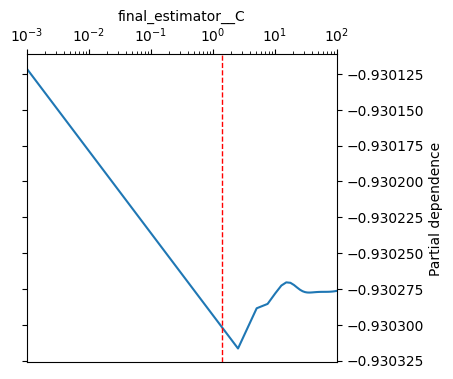

In [61]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(4, 4))
plot_objective(stack_cv.optimizer_results_[0], ax=ax)
plt.show()

In [62]:
# Train stack model 
stack = StackingClassifier(estimators=[('xgb', xgb_tuned), ('svc', svc_tuned), ('knn', knn_tuned), 
                                       ('lgbm', lgbm_tuned), ('rf', rf_tuned)], 
                                    final_estimator=LogisticRegression(max_iter=100, 
                                    C=1.4204, penalty='l2', solver='lbfgs'), cv=5) 

stack.fit(X_train, y_train)

<IPython.core.display.Javascript object>

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=0.1,
                                              gpu_id=0, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_ra...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=28,
                                              max_leaves=None,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=800, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=42, ...)),
                               ('svc',
                                SVC(C=8.551143274782264,
                                    gamma=0.22379351515634813, probability=True,
                                    random_state=42))],
                   final_estimator=LogisticRegression(C=1.4204))

In [63]:
# Evaluate the stack model on the training set
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'matthews_corrcoef']
cv_results = cross_validate(stack, X_train, y_train, cv=10, scoring=scoring)

print("Performance of the stack model on the training set:\nAcc: {:.4f}\nPr: {:.4f}\nSn: {:.4f}\nF1: {:.4f}\nMCC: {:.4f}\nAUROC: {:.4f}".format(
    np.median(cv_results['test_accuracy']),
    np.median(cv_results['test_precision']),
    np.median(cv_results['test_recall']),
    np.median(cv_results['test_f1']),
    np.median(cv_results['test_matthews_corrcoef']),
    np.median(cv_results['test_roc_auc'])
))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of the stack model on the training set:
Acc: 0.8511
Pr: 0.8451
Sn: 0.8673
F1: 0.8559
MCC: 0.7037
AUROC: 0.9300


In [64]:
# Evaluate the stack model on the test set
y_pred_stack = stack.predict(X_test)
y_proba_stack = stack.predict_proba(X_test)[:, 1]

print("Performance the stack model on the test set:")
print("Acc: {:.4f}".format(accuracy_score(y_test, y_pred_stack)))
print("Pr: {:.4f}".format(precision_score(y_test, y_pred_stack)))
print("Sn: {:.4f}".format(recall_score(y_test, y_pred_stack)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_stack)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_test, y_pred_stack)))
print("AUROC: {:.4f}".format(roc_auc_score(y_test, y_proba_stack)))

Performance the stack model on the test set:
Acc: 0.8593
Pr: 0.8705
Sn: 0.8442
F1: 0.8571
MCC: 0.7189
AUROC: 0.9306


In [65]:
# Save the model
#joblib.dump(stack, "model/stack.pkl")

['model/stack_xs.pkl']

## PR curves

[2025-04-14 20:02:07.474] Start to evalute the model:
[2025-04-14 20:02:07.478] Evaluating cascade layer = 0 
[2025-04-14 20:02:07.911] Evaluating cascade layer = 1 
[2025-04-14 20:02:08.488] Evaluating the predictor


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

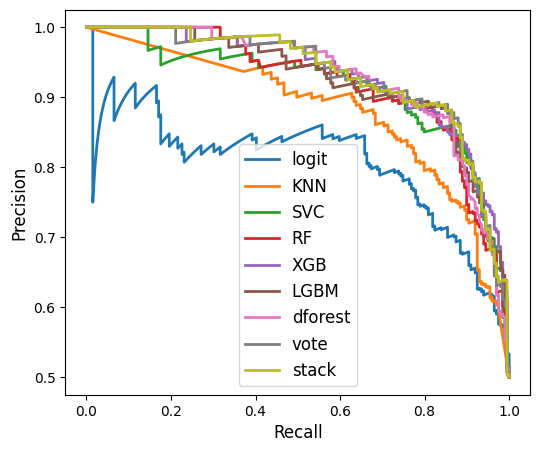

In [75]:
# Calculate decision function or probabilities for each model
y_thres_logit = logit_tuned.decision_function(X_test)
y_proba_knn = knn_tuned.predict_proba(X_test)[:, 1]
y_thres_svc = svc_tuned.decision_function(X_test)
y_proba_rf = rf_tuned.predict_proba(X_test)[:, 1]
y_proba_xgb = xgb_tuned.predict_proba(X_test)[:, 1]
y_proba_lgbm = lgbm_tuned.predict_proba(X_test)[:, 1]
y_proba_dforest = dforest_tuned.predict_proba(X_test)[:, 1]
y_proba_vote = vote.predict_proba(X_test)[:, 1]
y_proba_stack = stack.predict_proba(X_test)[:, 1]

# Calculate precision and recall for each model
precision_logit, recall_logit, _ = precision_recall_curve(y_test, y_thres_logit)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_proba_knn)
precision_svc, recall_svc, _ = precision_recall_curve(y_test, y_thres_svc)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_proba_lgbm)
precision_dforest, recall_dforest, _ = precision_recall_curve(y_test, y_proba_dforest)
precision_vote, recall_vote, _ = precision_recall_curve(y_test, y_proba_vote)
precision_stack, recall_stack, _ = precision_recall_curve(y_test, y_proba_stack)

# Function to plot precision-recall curve
def plot_PR_curve(precision, recall, label=None):
    plt.plot(recall, precision, linewidth=2, label=label)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel('Precision', fontsize=12)
    plt.xlabel('Recall', fontsize=12)
    plt.grid(False)

# Plot PR curves for all models
plt.figure(figsize=(6, 5))
plot_PR_curve(precision_logit, recall_logit, "logit")
plot_PR_curve(precision_knn, recall_knn, "KNN")
plot_PR_curve(precision_svc, recall_svc, "SVC")
plot_PR_curve(precision_rf, recall_rf, "RF")
plot_PR_curve(precision_xgb, recall_xgb, "XGB")
plot_PR_curve(precision_lgbm, recall_lgbm, "LGBM")
plot_PR_curve(precision_dforest, recall_dforest, "DF")
plot_PR_curve(precision_vote, recall_vote, "vote")
plot_PR_curve(precision_stack, recall_stack, "stack")

plt.legend(loc="best", fontsize=12)
plt.show()

## ROC curves

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

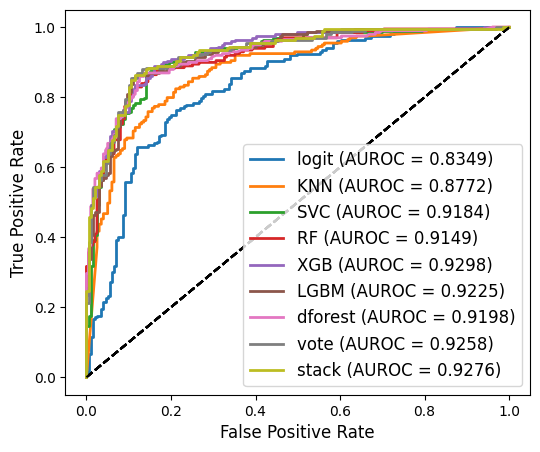

In [76]:
# Calculate ROC curves and AUC for each model
fpr, tpr, thresholds = roc_curve(y_test, y_thres_logit)
auroc = auc(fpr, tpr)

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_proba_knn)
auroc_knn = auc(fpr_knn, tpr_knn)

fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_thres_svc)
auroc_svc = auc(fpr_svc, tpr_svc)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
auroc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)
auroc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_proba_lgbm)
auroc_lgbm = auc(fpr_lgbm, tpr_lgbm)

fpr_dforest, tpr_dforest, thresholds_dforest = roc_curve(y_test, y_proba_dforest)
auroc_dforest = auc(fpr_dforest, tpr_dforest)

fpr_vote, tpr_vote, thresholds_vote = roc_curve(y_test, y_proba_vote)
auroc_vote = auc(fpr_vote, tpr_vote)

fpr_stack, tpr_stack, thresholds_stack = roc_curve(y_test, y_proba_stack)
auroc_stack = auc(fpr_stack, tpr_stack)

# Define a function to plot the ROC curve
def plot_roc_curve(fpr, tpr, auroc, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=f'{label} (AUROC = {auroc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.grid(False)

# Plot all ROC curves
plt.figure(figsize=(6, 5))
plot_roc_curve(fpr, tpr, auroc, "logit")
plot_roc_curve(fpr_knn, tpr_knn, auroc_knn, "KNN")
plot_roc_curve(fpr_svc, tpr_svc, auroc_svc, "SVC")
plot_roc_curve(fpr_rf, tpr_rf, auroc_rf, "RF")
plot_roc_curve(fpr_xgb, tpr_xgb, auroc_xgb, "XGB")
plot_roc_curve(fpr_lgbm, tpr_lgbm, auroc_lgbm, "LGBM")
plot_roc_curve(fpr_dforest, tpr_dforest, auroc_dforest, "DF")
plot_roc_curve(fpr_vote, tpr_vote, auroc_vote, "vote")
plot_roc_curve(fpr_stack, tpr_stack, auroc_stack, "stack")

plt.legend(loc="best", fontsize=12)
plt.savefig('algo_ROC.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [77]:
# Print classification report for xgb
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       199
           1       0.86      0.84      0.85       199

    accuracy                           0.85       398
   macro avg       0.85      0.85      0.85       398
weighted avg       0.85      0.85      0.85       398



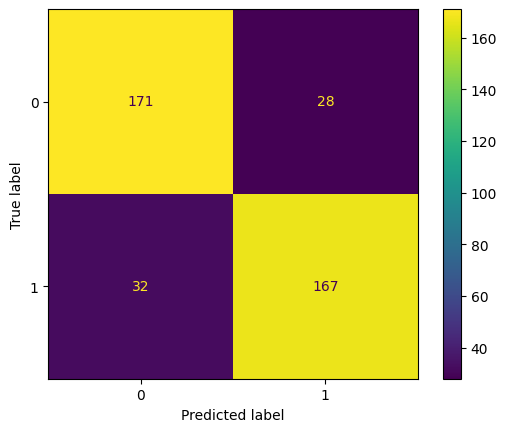

In [78]:
# Plot confusion matrix for xgb model
cm = confusion_matrix(y_test, y_pred_xgb, labels=xgb_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_tuned.classes_)
disp.plot()

In [79]:
# Visualize observations that were incorrectly labeled
Flabel = pd.DataFrame(X_test[y_test != y_pred_xgb])
Flabel

<IPython.core.display.Javascript object>

,Q,frac_CC,ECFP0,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,...,ECFP502,ECFP503,ECFP504,ECFP505,ECFP506,ECFP507,ECFP508,ECFP509,ECFP510,ECFP511
1985,0.423077,0.618852,0.314815,0.348837,0.333333,0.142857,0.760870,0.25,0.05,0.0,...,0.000000,0.238095,0.393939,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.000
504,0.346154,0.297600,0.611111,0.744186,0.561404,0.142857,0.054348,0.10,0.05,0.0,...,0.000000,0.047619,0.727273,0.181818,0.166667,0.00,0.000,0.000000,0.00,0.125
1069,0.346154,0.421472,0.191358,0.279070,0.175439,0.285714,0.347826,0.00,0.20,0.0,...,0.000000,0.190476,0.181818,0.000000,0.000000,0.25,0.000,0.000000,0.00,0.000
590,0.346154,0.470628,0.160494,0.162791,0.210526,0.071429,0.347826,0.20,0.05,0.0,...,0.000000,0.190476,0.181818,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.000
1702,0.346154,0.507028,0.358025,0.395349,0.315789,0.142857,0.184783,0.05,0.00,0.0,...,0.000000,0.047619,0.363636,0.090909,0.166667,0.00,0.125,0.111111,0.00,0.000
914,0.461538,0.221729,0.456790,0.581395,0.456140,0.285714,0.195652,0.00,0.10,0.0,...,0.333333,0.000000,0.515152,0.090909,0.166667,0.00,0.000,0.222222,0.50,0.000
1991,0.307692,0.466078,0.370370,0.372093,0.315789,0.142857,0.119565,0.10,0.15,0.1,...,0.166667,0.095238,0.363636,0.181818,0.000000,0.00,0.000,0.000000,0.00,0.000
1870,0.307692,0.611074,0.271605,0.325581,0.245614,0.071429,0.500000,0.25,0.10,0.0,...,0.000000,0.285714,0.333333,0.090909,0.000000,0.00,0.000,0.000000,0.00,0.000
2025,0.384615,0.381569,0.185185,0.232558,0.210526,0.071429,0.260870,0.15,0.05,0.0,...,0.000000,0.142857,0.212121,0.000000,0.000000,0.25,0.000,0.000000,0.00,0.000
639,0.269231,0.426481,0.339506,0.372093,0.315789,0.142857,0.076087,0.00,0.00,0.0,...,0.000000,0.000000,0.393939,0.090909,0.000000,0.00,0.000,0.000000,0.00,0.000


## Feature importance

In [80]:
# Find shap values
explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(X_test)

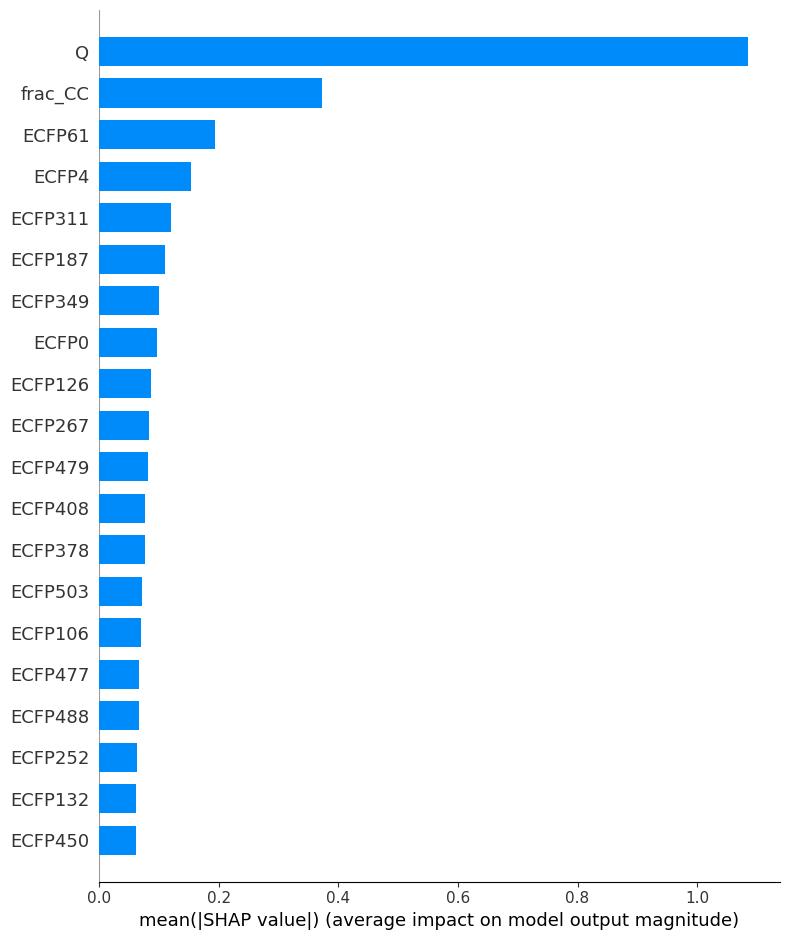

In [82]:
# Bar plot of shap values for class 1
shap.summary_plot(shap_values, X_test, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


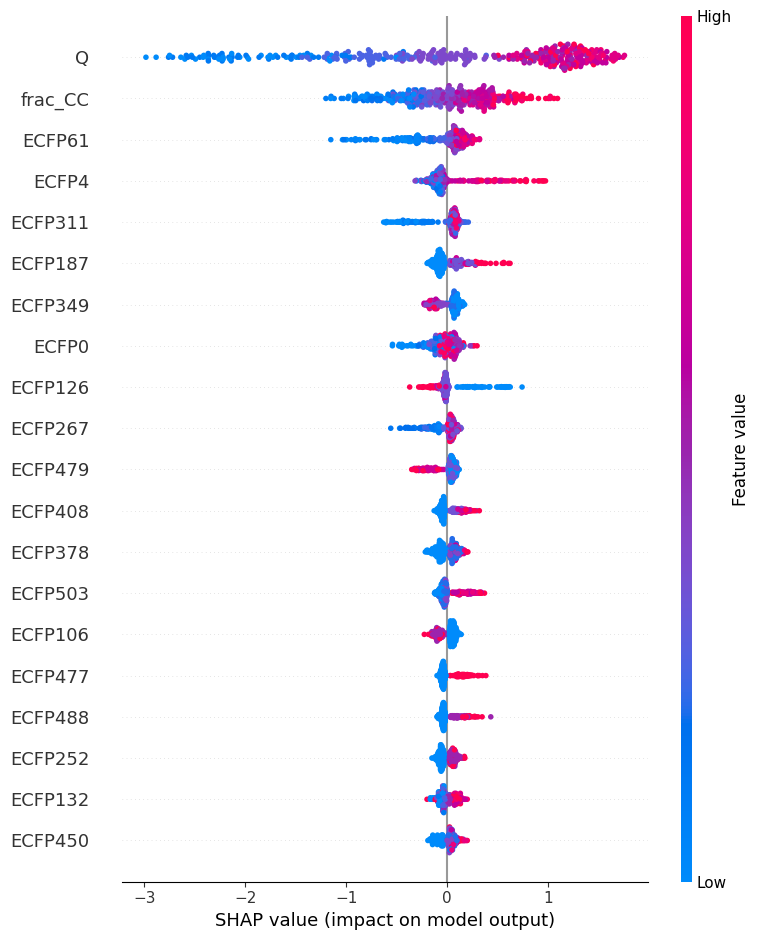

In [83]:
# Beeswarm plot of shap values
shap.summary_plot(shap_values, X_test)

## Friedman test

In [2]:
# Load data on algo
data = pd.read_csv('~/deepchem/5_stackcoli/stat/algo.csv')
data.head()

<IPython.core.display.Javascript object>

,algo,Acc,Pr,Sn,F1,MCC,AUROC
0,logit,0.7638,0.7536,0.7839,0.7685,0.5281,0.8349
1,logit,0.7940,0.8031,0.7789,0.7908,0.5882,0.8664
2,logit,0.8040,0.8103,0.7940,0.8020,0.6082,0.8451
3,logit,0.7915,0.7762,0.8191,0.7971,0.5838,0.8494
4,KNN,0.7990,0.7820,0.8291,0.8049,0.5991,0.8772


In [3]:
# Perform Friedman test
metrics = ['Acc', 'Pr', 'Sn', 'F1', 'MCC', 'AUROC']
results = []
significant_metrics = []

# Define number of conditions and blocks (subjects)
k = 9  # conditions
n = data[data['algo'] == 'logit'].shape[0]  # number of observations per condition

for metric in metrics:
    group1 = data[data['algo'] == 'logit'][metric]
    group2 = data[data['algo'] == 'KNN'][metric]
    group3 = data[data['algo'] == 'SVC'][metric]
    group4 = data[data['algo'] == 'RF'][metric]
    group5 = data[data['algo'] == 'XGB'][metric]
    group6 = data[data['algo'] == 'LGBM'][metric]
    group7 = data[data['algo'] == 'DF'][metric]
    group8 = data[data['algo'] == 'vote'][metric]
    group9 = data[data['algo'] == 'stack'][metric]
    
    # Perform Friedman test
    stat, p = stats.friedmanchisquare(group1, group2, group3, group4, group5, group6, group7, group8, group9)
    
    # Calculate Kendall's W as the effect size
    effect_size = stat / (n * (k - 1))
    
    # Determine significance description
    if p < 0.01:
        is_significant = 'highly significant'
    elif p < 0.05:
        is_significant = 'significant'
    else:
        is_significant = 'not significant'
    results.append([metric, stat, p, effect_size, is_significant])
    if is_significant != 'not significant':  
        significant_metrics.append(metric)

# Create a DataFrame for the Friedman test results
print("Friedman test results:")
results_df = pd.DataFrame(results, columns=['Metric', 'Friedman Statistic', 'p-value', "Kendall's W (Effect Size)", 'Significance'])
results_df

Friedman test results:


<IPython.core.display.Javascript object>

,Metric,Friedman Statistic,p-value,Kendall's W (Effect Size),Significance
0,Acc,21.046414,0.007025,0.657700,highly significant
1,Pr,21.405858,0.006144,0.668933,highly significant
2,Sn,21.299363,0.006393,0.665605,highly significant
3,F1,20.866667,0.007510,0.652083,highly significant
4,MCC,20.853556,0.007547,0.651674,highly significant
5,AUROC,26.400000,0.000897,0.825000,highly significant


In [5]:
# Perform Dunn's post hoc test with Bonferroni adjustment for significant metrics
post_hoc_results = {}

for metric in significant_metrics:
    # Prepare data for Dunn's test
    metric_data = pd.DataFrame({
        'Value': np.concatenate([
            data[data['algo'] == 'logit'][metric].values,
            data[data['algo'] == 'KNN'][metric].values,
            data[data['algo'] == 'SVC'][metric].values,
            data[data['algo'] == 'RF'][metric].values,
            data[data['algo'] == 'XGB'][metric].values,
            data[data['algo'] == 'LGBM'][metric].values,
            data[data['algo'] == 'DF'][metric].values,
            data[data['algo'] == 'vote'][metric].values,
            data[data['algo'] == 'stack'][metric].values
        ]),
        'Group': np.concatenate([
            ['logit'] * len(data[data['algo'] == 'logit'][metric]),
            ['KNN'] * len(data[data['algo'] == 'KNN'][metric]),
            ['SVC'] * len(data[data['algo'] == 'SVC'][metric]),
            ['RF'] * len(data[data['algo'] == 'RF'][metric]),
            ['XGB'] * len(data[data['algo'] == 'XGB'][metric]),
            ['LGBM'] * len(data[data['algo'] == 'LGBM'][metric]),
            ['DF'] * len(data[data['algo'] == 'DF'][metric]),
            ['vote'] * len(data[data['algo'] == 'vote'][metric]),
            ['stack'] * len(data[data['algo'] == 'stack'][metric])
        ])
    })

    # Perform Dunn's test
    dunn_result = sp.posthoc_dunn(metric_data, val_col='Value', group_col='Group', p_adjust='bonferroni')
    
    # Convert Dunn's result to DataFrame
    dunn_df = pd.DataFrame(dunn_result)
    post_hoc_results[metric] = dunn_df

# Combine all post hoc results into a single DataFrame for a comprehensive view
combined_post_hoc_df = pd.concat(post_hoc_results, names=['Metric', 'Comparison'])
print("Dunn's post hoc test results:")
combined_post_hoc_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dunn's post hoc test results:


DF       KNN      LGBM        RF       SVC       XGB  \
Metric Comparison                                                               
Acc    DF          1.000000  0.764510  1.000000  1.000000  1.000000  1.000000   
       KNN         0.764510  1.000000  0.329361  1.000000  1.000000  1.000000   
       LGBM        1.000000  0.329361  1.000000  1.000000  1.000000  1.000000   
       RF          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       SVC         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       XGB         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       logit       0.244174  1.000000  0.094044  0.951866  0.507048  1.000000   
       stack       1.000000  0.638609  1.000000  1.000000  1.000000  1.000000   
       vote        1.000000  0.105001  1.000000  1.000000  1.000000  1.000000   
Pr     DF          1.000000  0.446213  1.000000  1.000000  1.000000  1.000000   
       KNN         0.446213  1.000000  0.425508  1.000000  1.000000  1.000000   
       LGBM        1.000000  0.425508  1.000000  1.000000  1.000000  1.000000   
       RF          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       SVC         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       XGB         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       logit       0.302925  1.000000  0.288274  1.000000  0.808516  0.739931   
       stack       1.000000  0.302925  1.000000  1.000000  1.000000  1.000000   
       vote        1.000000  0.147802  1.000000  1.000000  1.000000  1.000000   
Sn     DF          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       KNN         1.000000  1.000000  0.323233  0.823060  1.000000  1.000000   
       LGBM        1.000000  0.323233  1.000000  1.000000  1.000000  1.000000   
       RF          1.000000  0.823060  1.000000  1.000000  1.000000  1.000000   
       SVC         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       XGB         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       logit       0.307638  1.000000  0.069263  0.205187  0.432519  1.000000   
       stack       1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       vote        1.000000  0.239309  1.000000  1.000000  1.000000  1.000000   
F1     DF          1.000000  0.773864  1.000000  1.000000  1.000000  1.000000   
       KNN         0.773864  1.000000  0.351124  1.000000  1.000000  1.000000   
       LGBM        1.000000  0.351124  1.000000  1.000000  1.000000  1.000000   
       RF          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       SVC         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       XGB         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       logit       0.164363  1.000000  0.064780  0.882892  0.538464  1.000000   
       stack       1.000000  0.773864  1.000000  1.000000  1.000000  1.000000   
       vote        1.000000  0.119354  1.000000  1.000000  1.000000  1.000000   
MCC    DF          1.000000  0.772655  1.000000  1.000000  1.000000  1.000000   
       KNN         0.772655  1.000000  0.302471  1.000000  1.000000  1.000000   
       LGBM        1.000000  0.302471  1.000000  1.000000  1.000000  1.000000   
       RF          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       SVC         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       XGB         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
       logit       0.247663  1.000000  0.085636  1.000000  0.537532  1.000000   
       stack       1.000000  0.617061  1.000000  1.000000  1.000000  1.000000   
       vote        1.000000  0.095679  1.000000  1.000000  1.000000  1.000000   
AUROC  DF          1.000000  0.741104  1.000000  1.000000  1.000000  1.000000   
       KNN         0.741104  1.000000  1.000000  1.000000  1.000000  0.261401   
       LGBM        1.000000  1.000000  1.000000  1.00000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

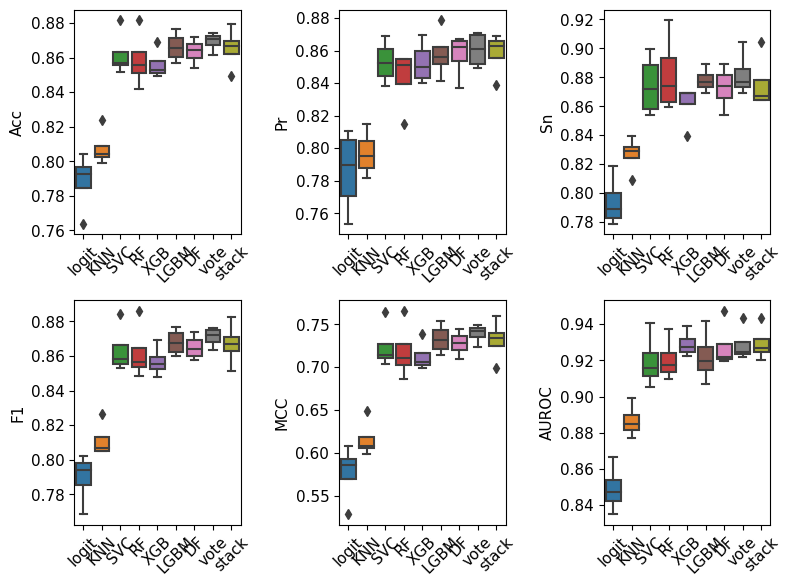

In [6]:
# Create box plots for each metric
plt.figure(figsize=(8, 6))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='algo', y=metric, data=data)
    plt.xticks(fontsize=11, rotation=45)
    plt.yticks(fontsize=11)
    plt.xlabel('')
    plt.ylabel(metric, fontsize=11)

# Adjust layout to prevent subplots from overlapping
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

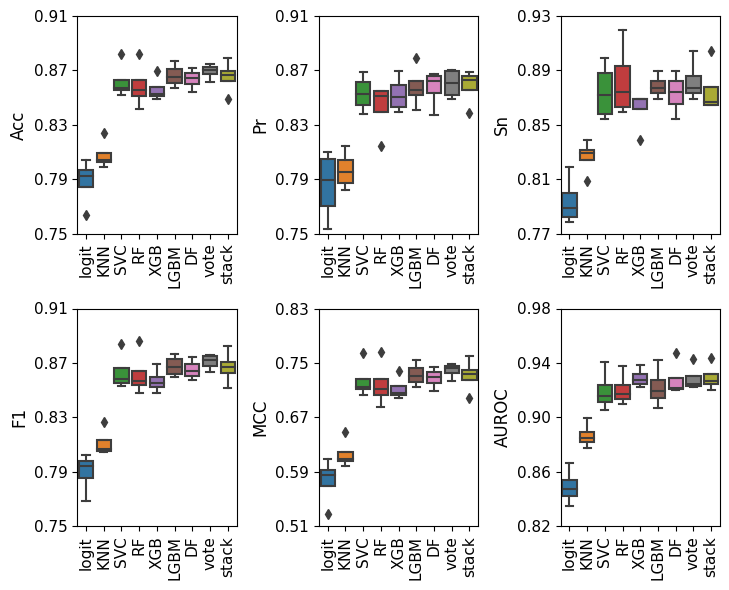

In [7]:
# Define the y-axis customization for each metric
y_axis_config = {
    'Acc': {'min': 0.75, 'max': 0.90, 'interval': 0.04, 'sig_figs': 2},
    'Pr': {'min': 0.75, 'max': 0.90, 'interval': 0.04, 'sig_figs': 2},
    'Sn': {'min': 0.77, 'max': 0.91, 'interval': 0.04, 'sig_figs': 2},
    'F1': {'min': 0.75, 'max': 0.90, 'interval': 0.04, 'sig_figs': 2},
    'MCC': {'min': 0.51, 'max': 0.78, 'interval': 0.08, 'sig_figs': 2},
    'AUROC': {'min': 0.82, 'max': 0.94, 'interval': 0.04, 'sig_figs': 2}
}

# Formatter function for significant figures
def format_func(value, sig_figs):
    return f'{value:.{sig_figs}f}'

plt.figure(figsize=(7.4, 6))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='algo', y=metric, data=data)
    plt.xticks(fontsize=11, rotation=90)
    plt.yticks(fontsize=11)
    plt.xlabel('')
    plt.ylabel(metric, fontsize=12)
    
    # Get configuration for current metric
    config = y_axis_config[metric]
    
    # Set y-axis limits
    plt.ylim(config['min'], config['max'])
    
    # Set y-axis ticks
    y_ticks = [round(x, config['sig_figs']) for x in np.arange(config['min'], config['max'] + config['interval'], config['interval'])]
    plt.yticks(y_ticks)
    
    # Format y-axis tick labels
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: format_func(x, config['sig_figs'])))

# Adjust layout to prevent subplots from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('algo.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()